## Practice 3

### Víctor Galván Fraile

In [279]:
#Primero, importamos todos los paquetes necesarios.
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xarray as xr
import netCDF4 as nc
from scipy import stats as sts
import scipy.stats as stats
from scipy import signal
from scipy.fft import fft 
from statsmodels.tsa import stattools 
from cartopy import crs as ccrs # Cartography library
import cartopy as car
import cmocean as cmo #Oceanographic library for colormaps
import plotly as plty
import matplotlib.patches as mpatches
import cartopy.io.img_tiles as cimgt
import numpy.linalg as linalg
import numpy.ma as ma
from scipy.stats import pearsonr
import matplotlib.dates as mdates


En primer lugar, vamos a crear el índice de la NAO

In [280]:
path_slp= 'C:/Users/ideapad 5 15ITL05/Desktop/Meteo UCM/1 cuatrimestre/Analisis de datos en meteorologia/Tema 5/Datos ej clase/slp_ERA20_1900-2010.nc'
slp_file= xr.open_dataset(path_slp)
slp_file

<xarray.Dataset>
Dimensions:    (longitude: 360, latitude: 181, time: 1332)
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * time       (time) datetime64[ns] 1900-01-01 1900-02-01 ... 2010-12-01
Data variables:
    msl        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2017-01-20 17:20:20 GMT by grib_to_netcdf-2.0.2: grib_to_ne...

In [281]:
#Vamos a tomar los puntos en Azores y en Islandia
Azores= [35, 335] #Ponta Delgada (São Miguel)
Islandia= [64.136319, 360-21.948231] #Reyjavick (o como se escriba)
escala= 1/100 #para tener la presión en hPa
Azores_point= slp_file.msl.sel(latitude=Azores[0],longitude=Azores[1],method='nearest')*escala
Islandia_point= slp_file.msl.sel(latitude=Islandia[0],longitude=Islandia[1],method='nearest')*escala
tiempo= slp_file.time

In [282]:
#ahora tomamos la anomalía estandarizada de presión entre estas dos estaciones
diferencia_presion= Azores_point-Islandia_point
#NAO= (diferencia_presion- diferencia_presion.mean())/diferencia_presion.std()
#hacemos la media y std por meses
NAO=((diferencia_presion.groupby('time.month')-diferencia_presion.groupby('time.month').mean('time'))).groupby('time.month')/diferencia_presion.groupby('time.month').std('time')
NAO

<xarray.DataArray 'msl' (time: 1332)>
array([ 0.74976099, -1.09638641, -1.86762482, ..., -0.22634874,
       -1.13392175, -2.87750959])
Coordinates:
  * time     (time) datetime64[ns] 1900-01-01 1900-02-01 ... 2010-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [283]:
TIEMPO = tiempo.indexes['time'].normalize()
TIEMPO

DatetimeIndex(['1900-01-01', '1900-02-01', '1900-03-01', '1900-04-01',
               '1900-05-01', '1900-06-01', '1900-07-01', '1900-08-01',
               '1900-09-01', '1900-10-01',
               ...
               '2010-03-01', '2010-04-01', '2010-05-01', '2010-06-01',
               '2010-07-01', '2010-08-01', '2010-09-01', '2010-10-01',
               '2010-11-01', '2010-12-01'],
              dtype='datetime64[ns]', name='time', length=1332, freq='MS')

<BarContainer object of 1332 artists>

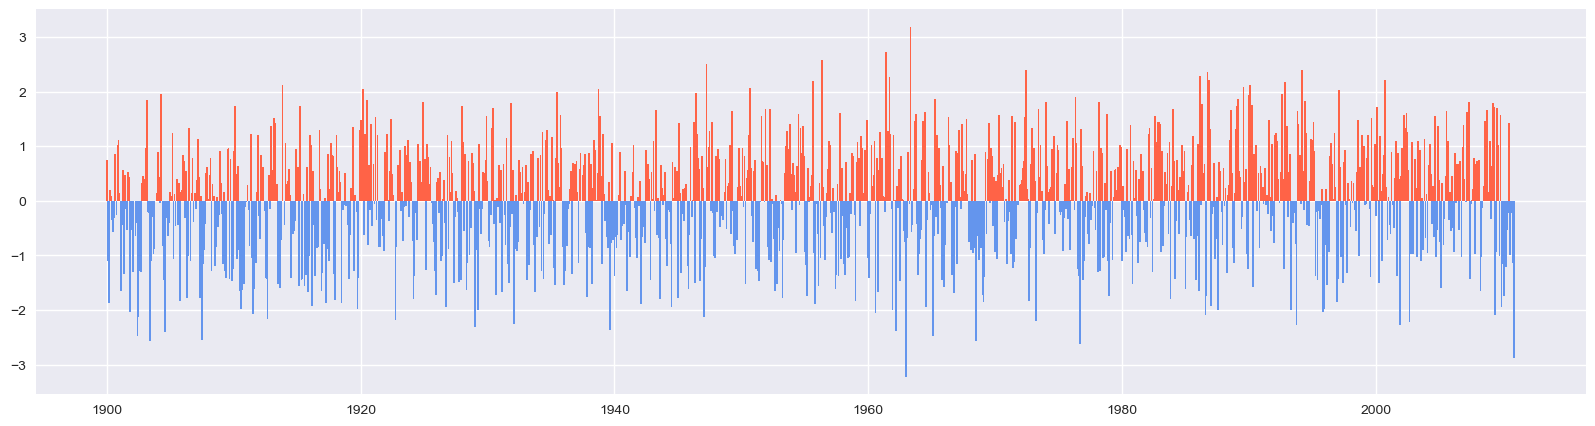

In [284]:
plt.style.use('seaborn')
fig, ax= plt.subplots(figsize=(20,5))
ax.bar(tiempo.indexes['time'].normalize(),NAO,width=50,color=np.where(NAO>0,'tomato','cornflowerblue'))

Ahora calculamos el índice del Niño

In [285]:
path_sst= 'C:/Users/ideapad 5 15ITL05/Desktop/Meteo UCM/1 cuatrimestre/Analisis de datos en meteorologia/Practica 1/Datos/HadISST1_sst_1870-2019.nc'
sst_file= xr.open_dataset(path_sst)
sst_file

<xarray.Dataset>
Dimensions:    (longitude: 360, latitude: 180, time: 1800)
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * time       (time) datetime64[ns] 1870-01-16T12:00:00 ... 2019-12-16T12:00:00
Data variables:
    sst        (time, latitude, longitude) float32 ...
Attributes:
    CDI:                        Climate Data Interface version 1.7.0rc4 (http...
    Conventions:                CF-1.0
    history:                    Thu Sep 10 13:01:22 2020: cdo setmissval,-100...
    source:                     HadISST
    institution:                Met Office Hadley Centre
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    supplementary_information:  Updates and supplementary information will be...
    comment:                    Data restrictions: for academic research use ...
    CDO:                        Climate Data Operators version 1.7.0rc6 (http...

In [286]:
lon_nino= [-150,-90]
lat_nino= [5,-5]


nino_3_region= sst_file.sel(latitude=slice(lat_nino[0],lat_nino[1]),longitude=slice(lon_nino[0],lon_nino[1]))
#calculamos la media espacial de SST para cada tiempo y calculamos la anomalía
nino_3= nino_3_region.sst.mean(axis=(1,2))
nino_3_region

<xarray.Dataset>
Dimensions:    (longitude: 60, latitude: 10, time: 1800)
Coordinates:
  * longitude  (longitude) float32 -149.5 -148.5 -147.5 ... -92.5 -91.5 -90.5
  * latitude   (latitude) float32 4.5 3.5 2.5 1.5 0.5 -0.5 -1.5 -2.5 -3.5 -4.5
  * time       (time) datetime64[ns] 1870-01-16T12:00:00 ... 2019-12-16T12:00:00
Data variables:
    sst        (time, latitude, longitude) float32 26.08 26.04 ... 23.08 23.12
Attributes:
    CDI:                        Climate Data Interface version 1.7.0rc4 (http...
    Conventions:                CF-1.0
    history:                    Thu Sep 10 13:01:22 2020: cdo setmissval,-100...
    source:                     HadISST
    institution:                Met Office Hadley Centre
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    supplementary_information:  Updates and supplementary information will be...
    comment:                    Data restrictions: for academic research use ...
    CDO:                        Climate Data Operators version 1.7.0rc6 (http...

In [287]:
ANOMALIA_nino_3= ((nino_3.groupby('time.month')-nino_3.groupby('time.month').mean('time'))).groupby('time.month')/nino_3.groupby('time.month').std('time')
ANOMALIA_nino_3

<xarray.DataArray 'sst' (time: 1800)>
array([-1.31801861, -1.37176839, -0.87842486, ...,  0.23864259,
        0.56651978,  0.34075136])
Coordinates:
  * time     (time) datetime64[ns] 1870-01-16T12:00:00 ... 2019-12-16T12:00:00
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [288]:
invierno_nino= ANOMALIA_nino_3.groupby('time.season')['DJF']
primavera_nino= ANOMALIA_nino_3.groupby('time.season')['MAM']
verano_nino= ANOMALIA_nino_3.groupby('time.season')['JJA']
otono_nino= ANOMALIA_nino_3.groupby('time.season')['SON']

invierno_NAO= NAO.groupby('time.season')['DJF']
primavera_NAO= NAO.groupby('time.season')['MAM']
verano_NAO= NAO.groupby('time.season')['JJA']
otono_NAO= NAO.groupby('time.season')['SON']

Dibujamos los índices en las diferentes estaciones del año, para ello nos ayudamos de la función 'season' de xarray

Text(0.5, 0.98, 'Índice del Niño 3')

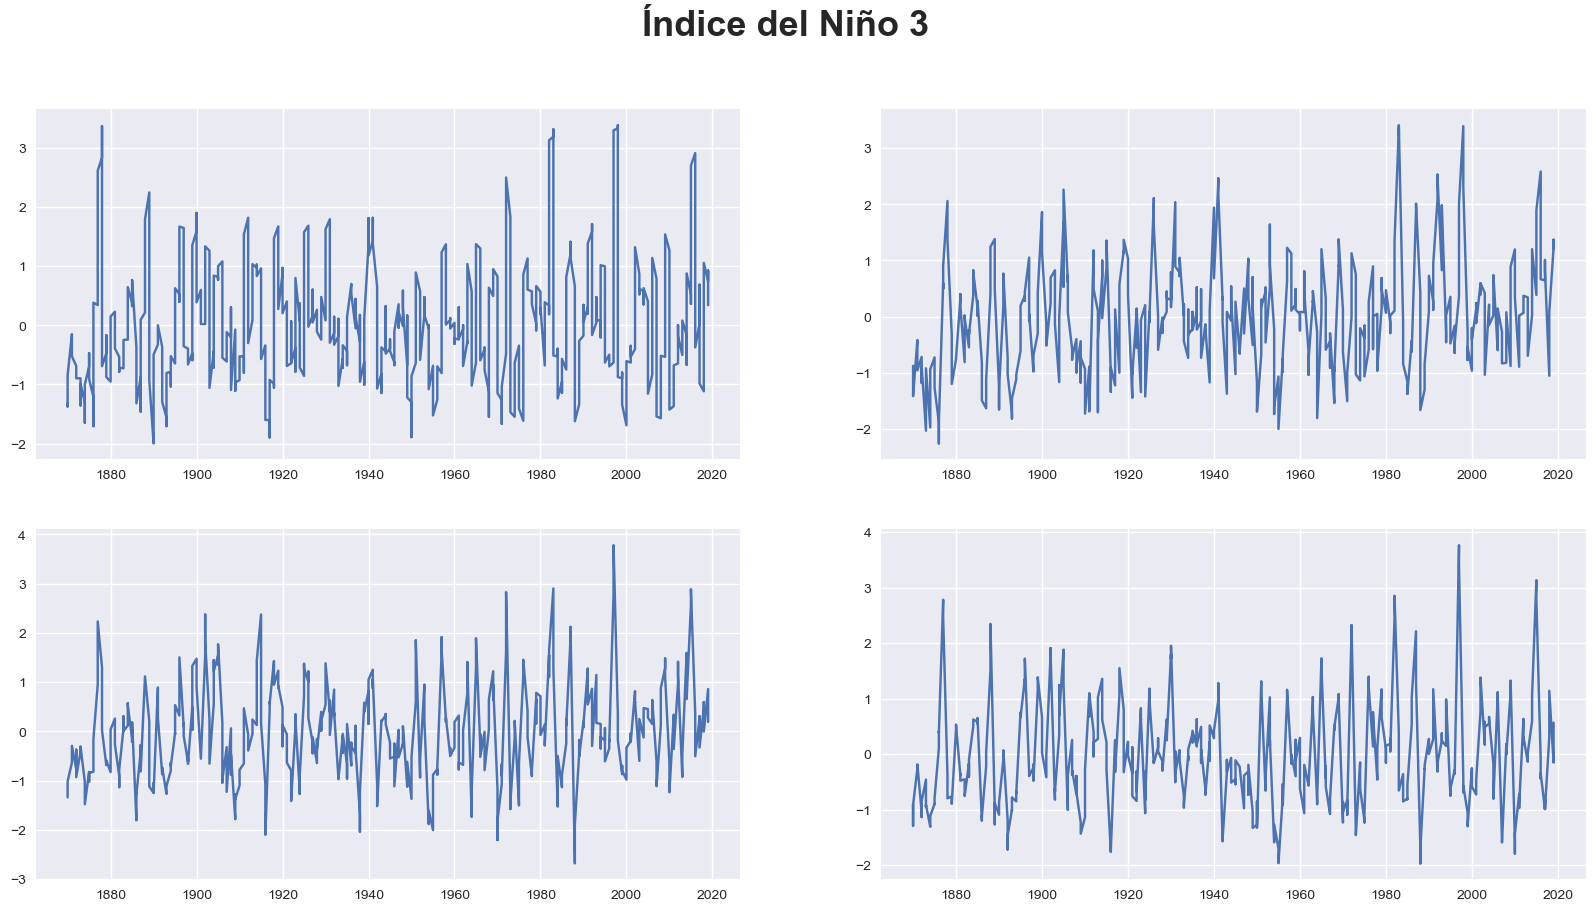

In [289]:
fig, ((ax1,ax2),(ax3,ax4))= plt.subplots(2,2,figsize=(20,10))
ax1.plot(invierno_nino.time.dt.year,invierno_nino)
ax2.plot(primavera_nino.time.dt.year,primavera_nino)
ax3.plot(verano_nino.time.dt.year,verano_nino)
ax4.plot(otono_nino.time.dt.year,otono_nino)
fig.suptitle('Índice del Niño 3',size=26,weight='bold')

Text(0.5, 0.98, 'Índice de la NAO')

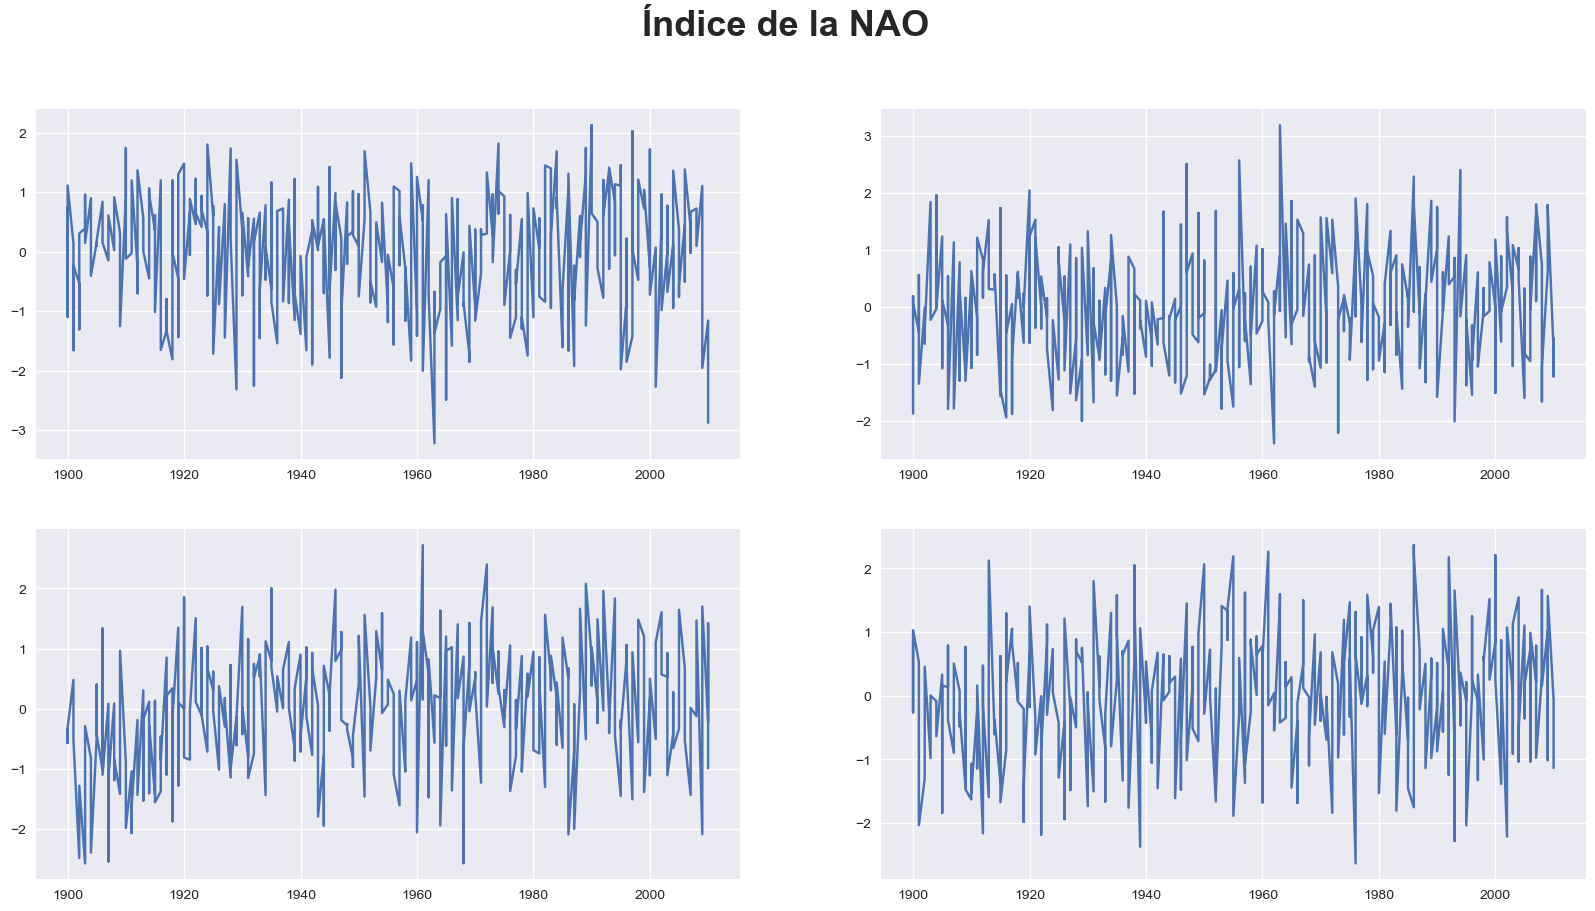

In [290]:
fig, ((ax1,ax2),(ax3,ax4))= plt.subplots(2,2,figsize=(20,10))
ax1.plot(invierno_NAO.time.dt.year,invierno_NAO)
ax2.plot(primavera_NAO.time.dt.year,primavera_NAO)
ax3.plot(verano_NAO.time.dt.year,verano_NAO)
ax4.plot(otono_NAO.time.dt.year,otono_NAO)
fig.suptitle('Índice de la NAO',size=26,weight='bold')

In [291]:
#Reducimos los datos para la comparación entre los dos índices a entre 1985-2000
invierno_NAO_red= invierno_NAO[(invierno_NAO.time.dt.year<=2000)&(invierno_NAO.time.dt.year>=1985)]
primavera_NAO_red= primavera_NAO[(primavera_NAO.time.dt.year<=2000)&(primavera_NAO.time.dt.year>=1985)]
verano_NAO_red= verano_NAO[(verano_NAO.time.dt.year<=2000)&(verano_NAO.time.dt.year>=1985)]
otono_NAO_red= otono_NAO[(otono_NAO.time.dt.year<=2000)&(otono_NAO.time.dt.year>=1985)]

invierno_nino_red= invierno_nino[(invierno_nino.time.dt.year<=2000)&(invierno_nino.time.dt.year>=1985)]
primavera_nino_red= primavera_nino[(primavera_nino.time.dt.year<=2000)&(primavera_nino.time.dt.year>=1985)]
verano_nino_red= verano_nino[(verano_nino.time.dt.year<=2000)&(verano_nino.time.dt.year>=1985)]
otono_nino_red= otono_nino[(otono_nino.time.dt.year<=2000)&(otono_nino.time.dt.year>=1985)]

<AxesSubplot:title={'center':'Índices del Niño 3 y la NAO para otoño'}>

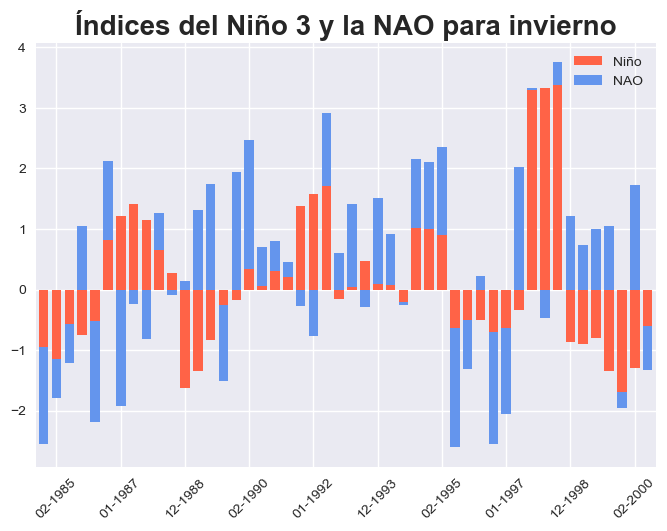

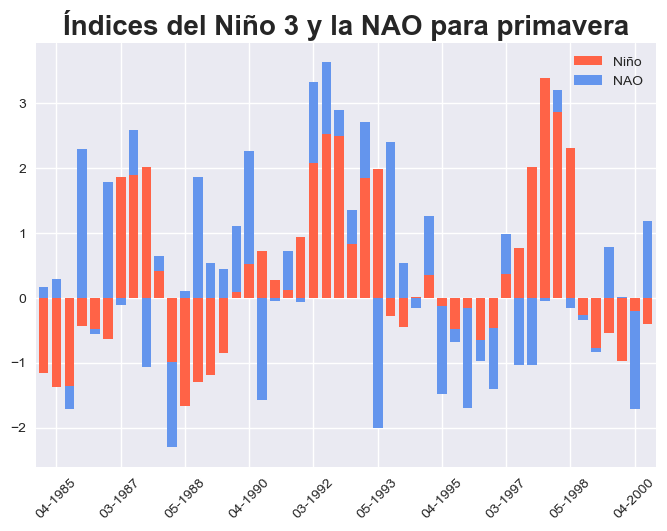

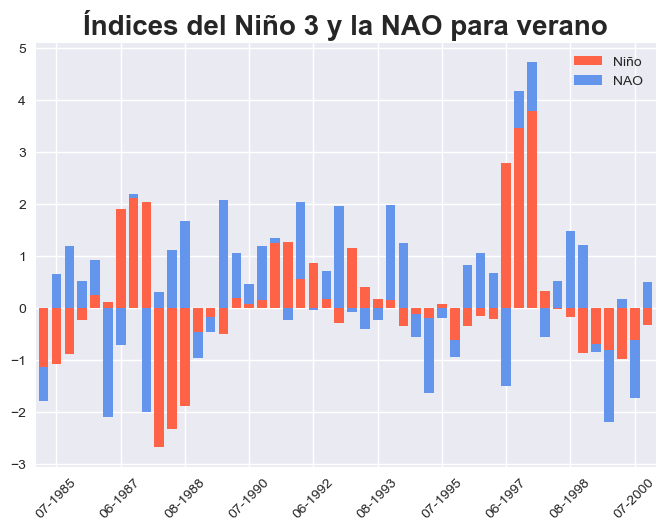

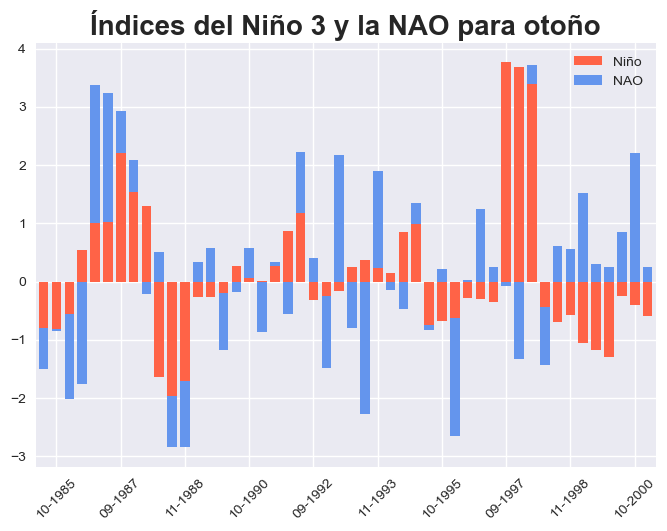

In [292]:
def data_arrays_topandasbarplot(niño,nao,estacion):
    testdata = pd.DataFrame({'Niño':niño, 'NAO':nao},index=pd.to_datetime(niño.time))
    testdata.index = [d.strftime("%m-%Y") for d in testdata.index]
    ax= testdata.plot.bar(rot=45,color={"Niño": "tomato", "NAO": "cornflowerblue"},width=0.75,stacked='True')
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    ax.set_title('Índices del Niño 3 y la NAO para '+str(estacion),size=20,weight='bold')
    return ax

data_arrays_topandasbarplot(invierno_nino_red,invierno_NAO_red,'invierno')
data_arrays_topandasbarplot(primavera_nino_red,primavera_NAO_red,'primavera')
data_arrays_topandasbarplot(verano_nino_red,verano_NAO_red,'verano')
data_arrays_topandasbarplot(otono_nino_red,otono_NAO_red,'otoño')

Una vez tenemos los índices en las diferentes estaciones, vamos a calcular las componentes principales del niño y la NAO en las diferentes estaciones

### ENSO
En la siguiente celda están las funciones necesarias para realizar este cálculo, así como el programa realizado por Belén de ejemplo

### I. Programa de Belén 

In [293]:
def season(Z,e1,e2,nyrs):
#para que funcione los datos Z tienen que estar con dimensiones nyrs,12,ns
#e1 y e2 son los meses inicial y final de las estaciones
#e1=2;e2=4 ;esta='MAM';
#e1=5;e2=7 ;esta='JJA';
#e1=6;e2=8 ;esta='JAS';
#e1=8;e2=10 ;esta='SON';
#e1=11;e2=1 ;esta='DJF';
#e1=10;e2=1 ;esta='NDJF';
   
    if e1==11:
        Zs1= Z[:-1,e1,:]
        Zs2= Z[1:,:e2,:].mean(1)
        n1=1
        n2=e2+1
        Zs=(Zs1*n1+Zs2*n2)/(n1+n2)
        nyrs=nyrs-1
    elif e1>e2:
        Zs1= Z[:-1,e1:11,:].mean(1)
        Zs2= Z[1:,:e2,:].mean(1)
        n1=12-e1
        n2=e2+1
        Zs=(Zs1*n1+Zs2*n2)/(n1+n2)
        nyrs=nyrs-1
    else:
        Zs = Z[:,e1:e2,:].mean(1)

    return Zs ,nyrs

def quitonans(mat):
    out = mat[:,~np.isnan(mat.mean(axis = 0))]
    return out

def pongonans(matred,mat):
    out = mat.mean(axis = 0 )
    out[:] = np.nan
    out[~np.isnan(mat.mean(axis = 0))] = matred
    return out

# Esta función calcula correlaciones en datos de mas de una dimensión

def pearsonr_2D(y, x):
    upper = np.sum((x - np.mean(x)) * (y - np.mean(y, axis=1)[:,None]), axis=1)
    lower = np.sqrt(np.sum(np.power(x - np.mean(x), 2)) * np.sum(np.power(y - np.mean(y, axis=1)[:,None], 2), axis=1))
    rho = upper / lower
    return rho

# Esta función calcula mapas de Correlacion y Regresion a partir de un índice

def IndexRegrCorr(Data,Index,alfa,sig,pp):
    try:
        [ns,nt]=Data.shape # n1=espacio, n2=tiempo
    except ValueError:
        # si Data es un índice
        ns=1
        nt=len(Data)
        Data = np.array([Data])
        
    cor=ma.empty([ns,])
    Pvalue=ma.empty([ns,])
    reg=np.dot(Data,Index)/(nt-1)
    
    for nn in range(ns): 
        bb=pearsonr(Data[nn,:],Index) 
        cor[nn]=bb[0]
        Pvalue[nn]=bb[1]

    if sig == 'test-t':
        cor_sig=ma.masked_where(Pvalue>alfa,cor)
        reg_sig=ma.masked_where(Pvalue>alfa,reg)
        
    if sig == 'MonteCarlo':
        corp = ma.empty([ns,pp])
        for p in range(pp):
            corp[:,p] = pearsonr_2D(Data,np.random.permutation(Index))
            # aquí uso la función pearsonr_2D y me ahorro un bucle en ns
        
        for nn in range(ns): 
            hcor = np.count_nonzero((cor[nn]>0)&(corp[nn,:]<cor[nn])|(cor[nn]<0)&(corp[nn,:]>cor[nn]))
            # nivel de confianza
            Pvalue[nn] = hcor/pp
            
        #cor_sig = ma.masked_where(Pvalue<(1-alfa),cor)
        #reg_sig = ma.masked_where(Pvalue<(1-alfa),reg)
        cor_sig = ma.masked_where(Pvalue>(1-alfa),cor)
        reg_sig = ma.masked_where(Pvalue>(1-alfa),reg)#en el de Belén está marcado lo que es siginifcativo, con lo que aquí el signo va al revés
        
    return cor,Pvalue,cor_sig,reg,reg_sig

# Esta función calcula las EOFS
def eof(y, nm, alfa,test,perm):
    # Y es el campo
    # alfa es el nivel de significacion. Por ejemplo alfa=0.01 quiere decir un nivel de confianza del 99%\n",
    # nm es el numero de modos y nmes es simplemente si por cada año tenemos un dato medio (media de DEF) o el dato
    # intraestacional (diciembre, enero y febrero por separado).Normalmente nmes es 1
    # en test has de poner o 'Montecarlo' o 't-test'
    #tambien has de poner el numero de permutaciones, por ejemplo 100
    y2 =np.transpose(quitonans(np.transpose(y)))
    ny, nt = y.shape
    ny2,nt=y2.shape
    # first you calculate the covariance matrix
    C = np.dot(y2,np.transpose(y2))
    R, d, R = linalg.svd(C)
    fvar = d / np.sum(d)
    fig, ax = plt.subplots(figsize=(7,5))
    plt.plot(fvar[:nm], color='Blue', marker='o', label='Evolucion de autovalores')
    plt.legend()
    plt.grid()
    # Y había que transponerla si originariamente era (espacio, tiempo), pero ATN_e es (tiempo, espacio) así
    # que no se transpone. Aqui uso toda la matriz 
    PC = np.dot(np.transpose(y2), R[:, :nm+1])
    print(PC.shape)
    #fig, ax = plt.subplots(figsize=(10, 5))
    #plt.plot(PC[:,0], color='Blue', label='PC1')
    #plt.legend()
    #plt.grid()
    # calculamos las anomalías estandarizadas
    # estandarizo la Pc
    PCs=(PC-np.mean(PC,0))/np.std(PC)

    Cor = ma.empty([ny, nm]);
    pvalCor = ma.empty([ny, nm]);
    Cor_sig = ma.empty([ny, nm]);
    Reg = ma.empty([ny, nm]);
    Reg_sig = ma.empty([ny, nm])
    #Aqui uso la que tienen nan porque ya no me va a dar problemas, pero le pongo numeros
    y=np.nan_to_num(y,nan=-999)

    for i in range(nm):
        Cor[:, i], pvalCor[:, i], Cor_sig[:, i], Reg[:, i], Reg_sig[:, i] = IndexRegrCorr(y, np.transpose(PCs[:,i]), alfa,test,perm)

    return Cor, Cor_sig, Reg, Reg_sig, PCs, fvar


def dibujo_1_mapa_cartopy(A,lon,lat,levs,cmap1,l1,titulo, ax):
    im=ax.contourf(lon,lat,A
                   ,cmap=cmap1,levels=levs,extend='both',transform=ccrs.PlateCarree())
    ax.coastlines(linewidth=1);
    ax.set_title(titulo,fontsize=15)
    cbar = plt.colorbar(im, extend='neither', spacing='proportional',
                orientation='vertical', shrink=0.7, format="%2.2f")
    cbar.set_label(l1, size=10)
    cbar.ax.tick_params(labelsize=10) 
    
# Esta función te proporciona anomalías ya sean estandarizadas o no, al introducir un campo con dimension (espacio,tiempo)
def anom(X, nyr, par):
    # si par = st quiere decir que estandarizo. Si no, no (pongo, por ejemplo,'pp')
    ns, nt = np.shape(
        X)  # una de las dimensiones es tiempo, la segunda, y la otra puede ser el numero de modos, o de espacios..
    nmes = int(nt / (nyr));

    # dividimos el número de tiempos por el numero de años porque en caso de que queramos calcular
    # anomalias estacionales de una secuencia mensual (enero-media(diciembre-enero-febrero)) en lugar de una media estacional

    An = ma.empty([ns, nt])

    for i in range(ns):
        A = X[i, :].reshape(nyr, nmes)
        mA = np.mean(A)
        for j in range(0, nyr):
            A[j, :] = A[j, :] - mA

        if par == 'st':

            stdA = ma.empty([nmes, ])
            for k in range(nmes):
                stdA[k] = np.std(A[:, k])
                if stdA[k] != 0:
                    A[:, k] = A[:, k] / stdA[k]

        # se reorganizan los datos
        A = np.transpose(A.reshape(nyr * nmes, 1))
        An[i, :] = A;

    return An

def region(data,lat,lon,lonmin,lonmax,latmin,latmax):
    # data[t,lon,lat]
    latc=lat[(lat>=latmin)&(lat<=latmax)]
    lonc=lon[(lon>=lonmin)&(lon<=lonmax)]
    datac = data[:,:,(lon>=lonmin)&(lon<=lonmax)][:,(lat>=latmin)&(lat<=latmax),:]
    return datac,latc,lonc

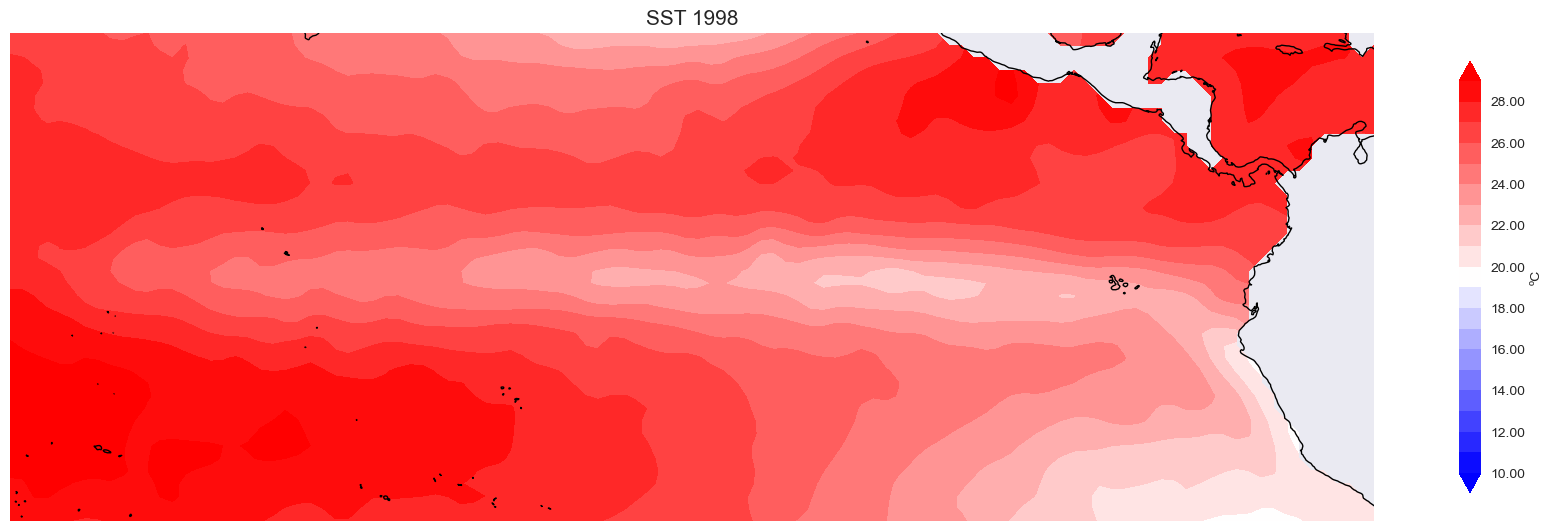

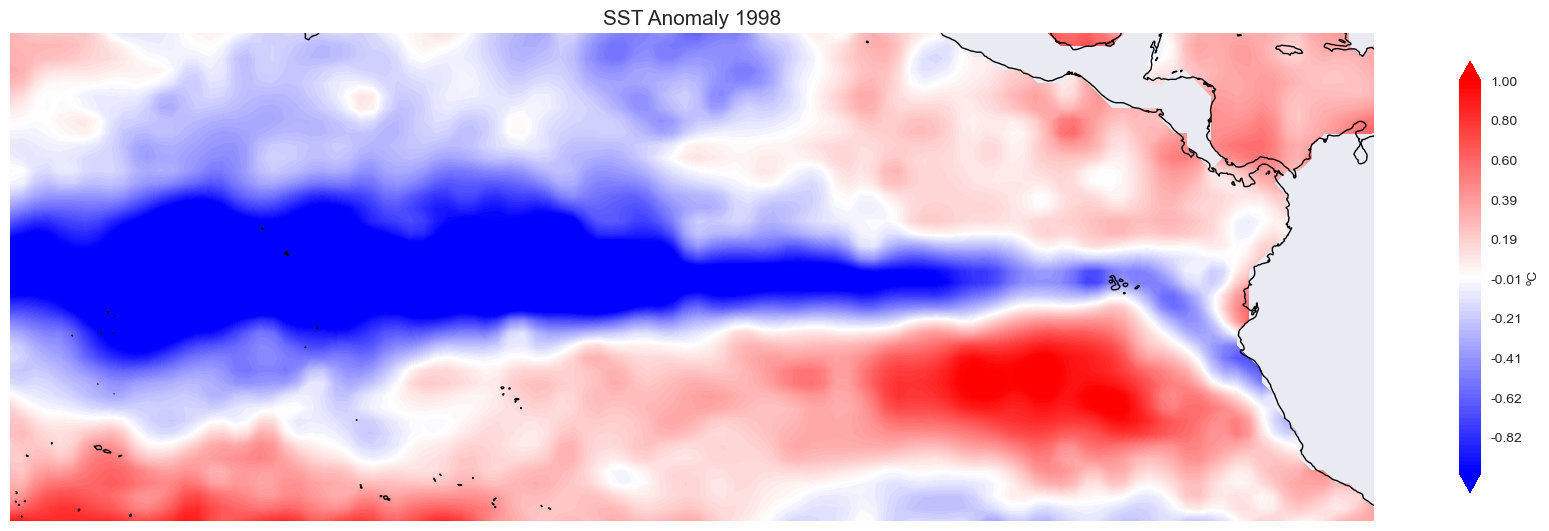

In [294]:
fil= sst_file.copy()
lon = fil.longitude
lat = fil.latitude
sst = fil.sst
nt, nlat, nlon = sst.shape
nm = 12
nyearssst = int(nt/nm)

lonmin,lonmax,latmin,latmax = -270, -70, -20, 20

SST,lat,lon=region(sst,lat,lon,lonmin,lonmax,latmin,latmax)
yrsst=np.linspace(1870,2019,150)
SST=SST[:150*12,:,:]
SST=np.array(SST)
SST=np.reshape(SST, (150,12,len(lat),len(lon)))
#Cojo solo el año 1998. diciembre:
Z1998=SST[yrsst==1998,11,:,:]
fig = plt.figure(figsize=(22,8)) 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))
dibujo_1_mapa_cartopy(np.reshape(Z1998,(len(lat),len(lon))),lon,lat,np.arange(10,30), 'bwr', 'ºC','SST 1998',ax)
# reorganizo los datos para que estén en numero de años, numero de meses y espacio
SST=np.reshape(SST, (len(yrsst),12,len(lon)*len(lat)))
#ahora calculo las medias estacionales, por ejemplo del mes 9 (octubre) al mes 1 (febrero)
SST_sea,ny1=season(SST,9,1,111)
# Ahora voy a calcular las anomalias
SST_sea_an=anom(np.transpose(SST_sea),1,'pp')
fig = plt.figure(figsize=(22,8)) 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))
dibujo_1_mapa_cartopy(np.reshape(SST_sea_an[:,np.where(yrsst==1998)],(len(lat),len(lon))),lon,lat,np.linspace(-1,1,100), 'bwr', 'ºC','SST Anomaly 1998',ax)

In [295]:
y2 =quitonans(np.transpose(SST_sea_an))
ny, nt = y2.shape
nyr = int(nt / 1)
    # first you calculate the covariance matrix
C = np.dot(np.transpose(y2),y2)
R, d, R = linalg.svd(C)

In [296]:
fvar=(d)/sum(d)
sum(fvar[:3])

0.8976425336873473

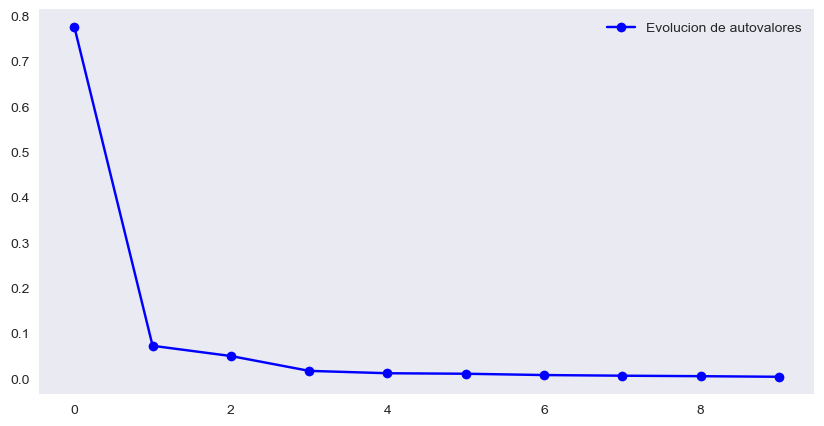

In [297]:
fig,ax = plt.subplots(figsize = (10,5))
plt.plot(fvar[:10],color='Blue',marker='o',label='Evolucion de autovalores')
plt.legend()
plt.grid()

Text(0.5, 1.0, 'Primera componente principal fvar=0.78')

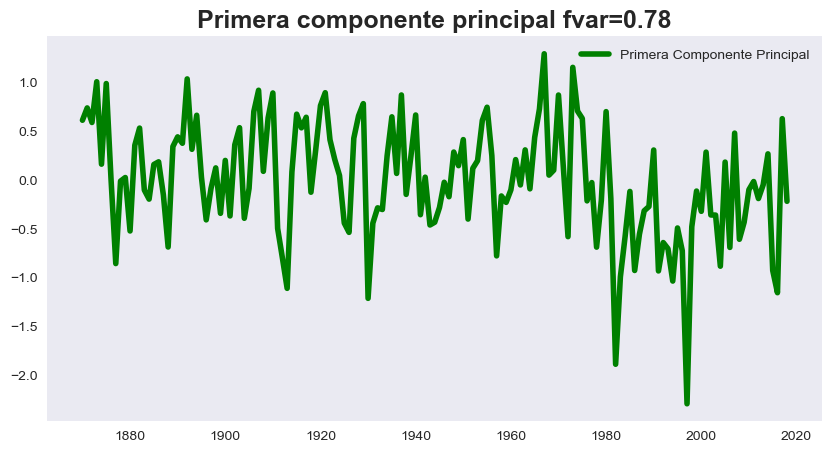

In [298]:
PC=np.dot(y2,R[:,:4])
#Y había que transponerla si originariamente era (espacio, tiempo), pero ATN_e es (tiempo, espacio) así 
#que no se transpone
PC=np.transpose(np.dot(y2,R[:,:4]))
#calculamos las anomalías estandarizadas 
PCs=(PC-np.mean(PC,0))/np.std(PC)

fig,ax=plt.subplots(figsize = (10,5))
ax.plot(range(1870,2019),PCs[0,:],linewidth= 4,color='green',label='Primera Componente Principal')
ax.grid()
ax.legend()
ax.set_title('Primera componente principal fvar='+ str( round(fvar[0],2)),fontsize=18,weight='bold')

C:\Anaconda\envs\analisisdatosucm\lib\site-packages\scipy\stats\_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


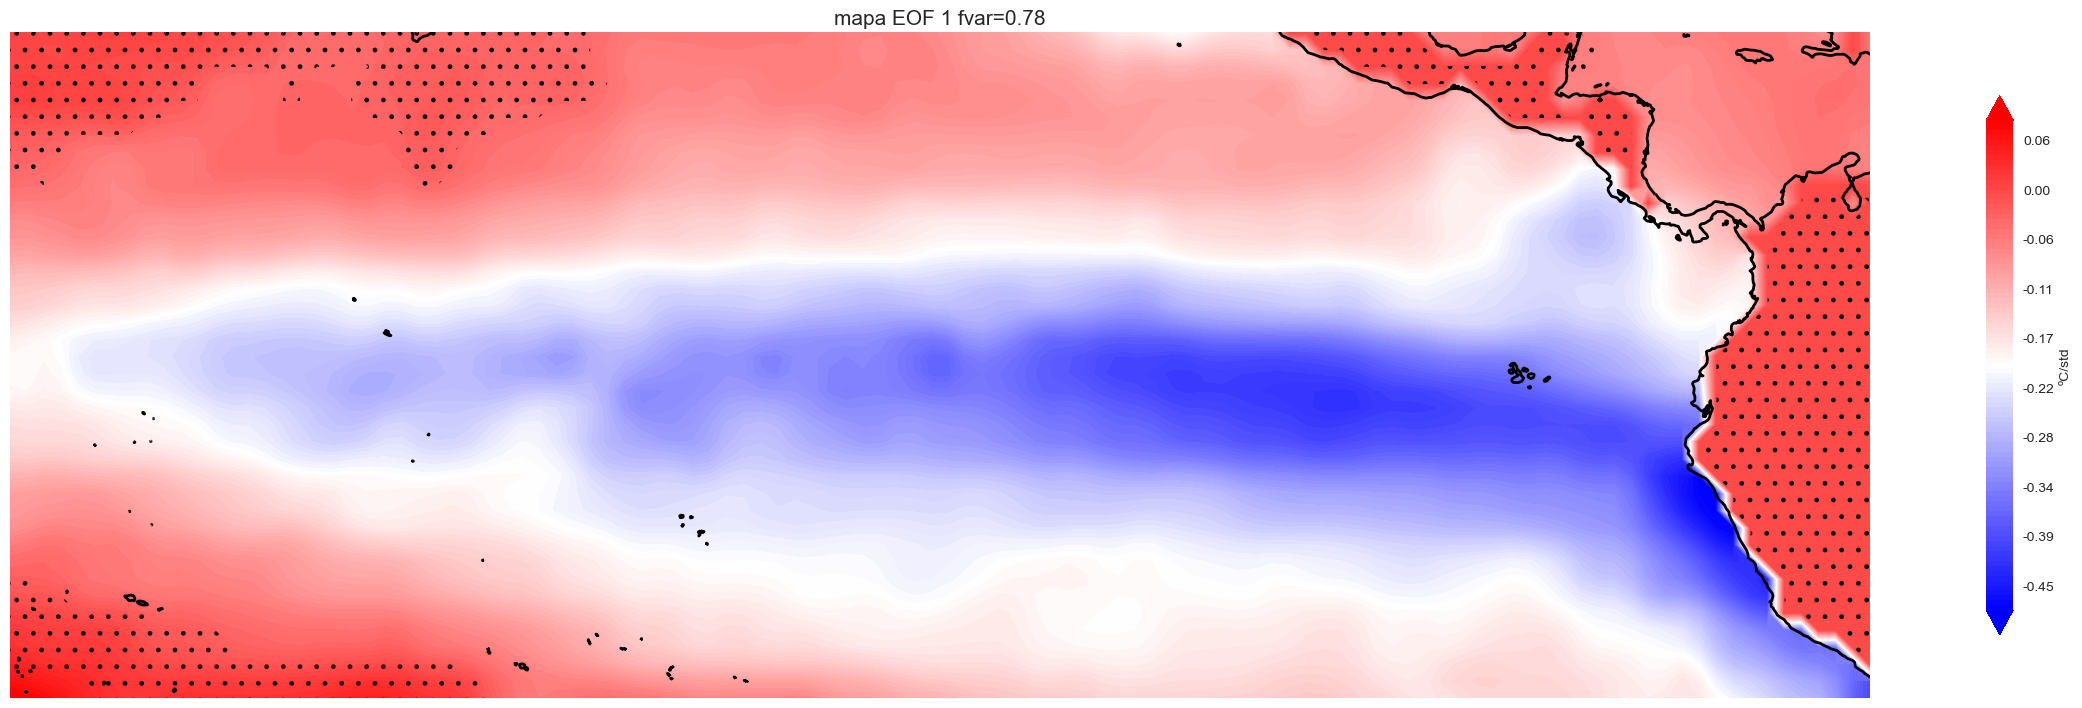

In [299]:
Y1=np.nan_to_num(SST_sea_an,nan=-999)
cor1,Pvalue1,cor_sig1,reg1,reg1_sig=IndexRegrCorr(Y1, PCs[0,:],0.01,'MonteCarlo',100)
fig = plt.figure(figsize=(30,10)) 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))
dibujo_1_mapa_cartopy(np.reshape(reg1,(len(lat),len(lon))),lon,lat,np.linspace(reg1.min(),reg1.max(),100),'bwr','ºC/std','mapa EOF 1 fvar='+ str( round(fvar[0],2)), ax)
ax.contourf(lon,lat,np.reshape(reg1_sig,(len(lat),len(lon))),alpha=0,cmap='bwr',levels=np.linspace(reg1_sig.min(),reg1_sig.max(),100),hatches='.')
ax.coastlines(linewidth=2)

(149, 4)


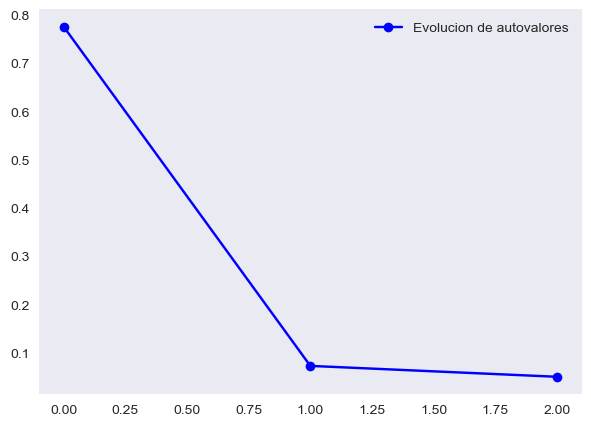

In [300]:
# Esto se hubiera hecho con una funcion (ya teniendo en cuenta el tener que quitar nan y demás)
Cor, Cor_sig, Reg, Reg_sig, PCs, fvar = eof (SST_sea_an, 3, 0.1,'MonteCarlo',100)

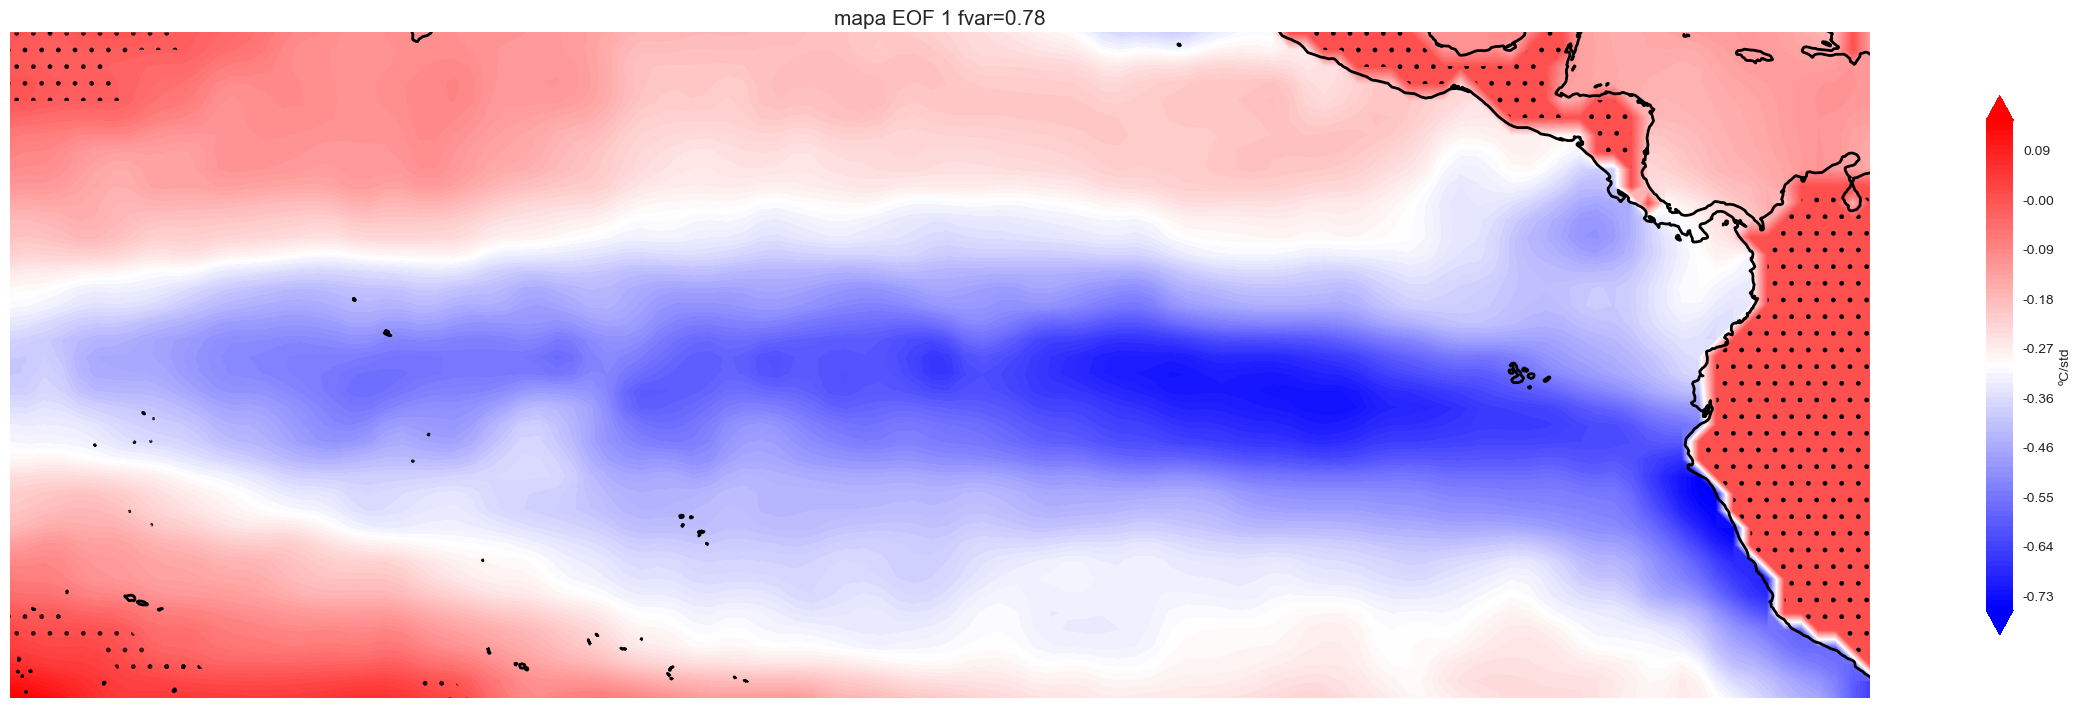

In [301]:
fig = plt.figure(figsize=(30,10)) 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))
dibujo_1_mapa_cartopy(np.reshape(Reg[:,0],(len(lat),len(lon))),lon,lat,np.linspace(Reg[:,0].min(),Reg[:,0].max(),100),'bwr','ºC/std','mapa EOF 1 fvar='+ str( round(fvar[0],2)), ax)
ax.contourf(lon,lat,np.reshape(Reg_sig[:,0],(len(lat),len(lon))),alpha=0,cmap='bwr',levels=np.linspace(Reg_sig[:,0].min(),Reg_sig[:,0].max(),100),hatches='.')
ax.coastlines(linewidth=2)

In [302]:
fil_enso= sst_file.copy()
lon_enso = fil_enso.longitude
lat_enso = fil_enso.latitude
sst_enso = fil_enso.sst
nt_enso, nlat_enso, nlon_enso = sst_enso.shape
nm_enso = 12
nyearssst_enso = int(nt_enso/nm_enso)

lonmin,lonmax,latmin,latmax = -270, -70, -20, 20
SST,lat_enso,lon_enso=region(sst_enso,lat_enso,lon_enso,lonmin,lonmax,latmin,latmax)
yrsst_enso=np.linspace(1870,2019,150)
SST=SST[:150*12,:,:]
SST=np.array(SST)
SST=np.reshape(SST, (150,12,len(lat_enso),len(lon_enso)))
# reorganizo los datos para que estén en numero de años, numero de meses y espacio
SST=np.reshape(SST, (len(yrsst_enso),12,len(lon_enso)*len(lat_enso)))

In [314]:
def componentes_principales(data,estacion,e1,e2,unidad,lat,lon):
    SST_sea,ny1=season(data,e1,e2,150) 
    SST_sea_an=anom(np.transpose(SST_sea),1,'pp')
    Cor, Cor_sig, Reg, Reg_sig, PCs, fvar = eof (SST_sea_an, 3, 0.1,'MonteCarlo',100)
    fig = plt.figure(figsize=(15,15)) 
    ax1 = fig.add_subplot(311, projection=ccrs.PlateCarree(0))
    maximo_1= np.max((abs(Reg[:,0].min()),abs(Reg[:,0].max())))
    dibujo_1_mapa_cartopy(np.reshape(Reg[:,0],(len(lat),len(lon))),lon,lat,np.linspace(-maximo_1,+maximo_1,100),'bwr',str(unidad),'Mapa EOF 1 fvar='+ str( round(fvar[0],2)), ax1)
    ax1.contourf(lon,lat,np.reshape(Reg_sig[:,0],(len(lat),len(lon))),alpha=0,cmap='bwr',levels=np.linspace(Reg_sig[:,0].min(),Reg_sig[:,0].max(),100),hatches='+')
    ax1.coastlines(linewidth=2)

    ax2 = fig.add_subplot(312, projection=ccrs.PlateCarree(0))
    maximo_2= np.max((abs(Reg[:,1].min()),abs(Reg[:,1].max())))
    dibujo_1_mapa_cartopy(np.reshape(Reg[:,1],(len(lat),len(lon))),lon,lat,np.linspace(-maximo_2,+maximo_2,100),'bwr',str(unidad),'mapa EOF 2 fvar='+ str( round(fvar[1],2)), ax2)
    ax2.contourf(lon,lat,np.reshape(Reg_sig[:,1],(len(lat),len(lon))),alpha=0,cmap='bwr',levels=np.linspace(Reg_sig[:,1].min(),Reg_sig[:,1].max(),100),hatches='+')
    ax2.coastlines(linewidth=2)

    ax3 = fig.add_subplot(313, projection=ccrs.PlateCarree(0))   
    maximo_3= np.max((abs(Reg[:,2].min()),abs(Reg[:,2].max())))
    dibujo_1_mapa_cartopy(np.reshape(Reg[:,2],(len(lat),len(lon))),lon,lat,np.linspace(-maximo_3,+maximo_3,100),'bwr',str(unidad),'mapa EOF 3 fvar='+ str( round(fvar[2],2)), ax3)
    ax3.contourf(lon,lat,np.reshape(Reg_sig[:,2],(len(lat),len(lon))),alpha=0,cmap='bwr',levels=np.linspace(Reg_sig[:,2].min(),Reg_sig[:,2].max(),100),hatches='+')
    ax3.coastlines(linewidth=2)
    fig.suptitle('Componentes Principales en '+str(estacion),size=25,weight='bold')
    return Cor, Cor_sig, Reg, Reg_sig, PCs, fvar, fig

### II. Invierno

(149, 4)


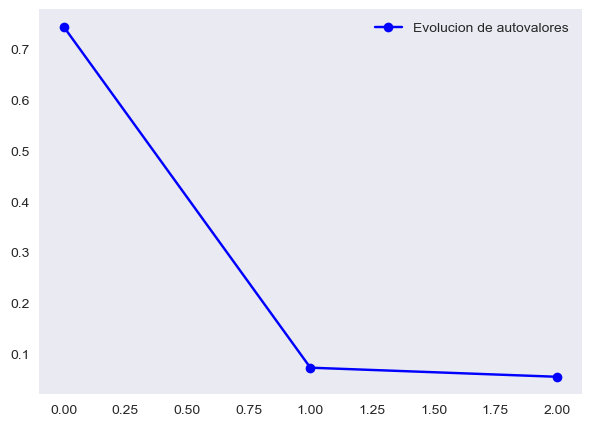

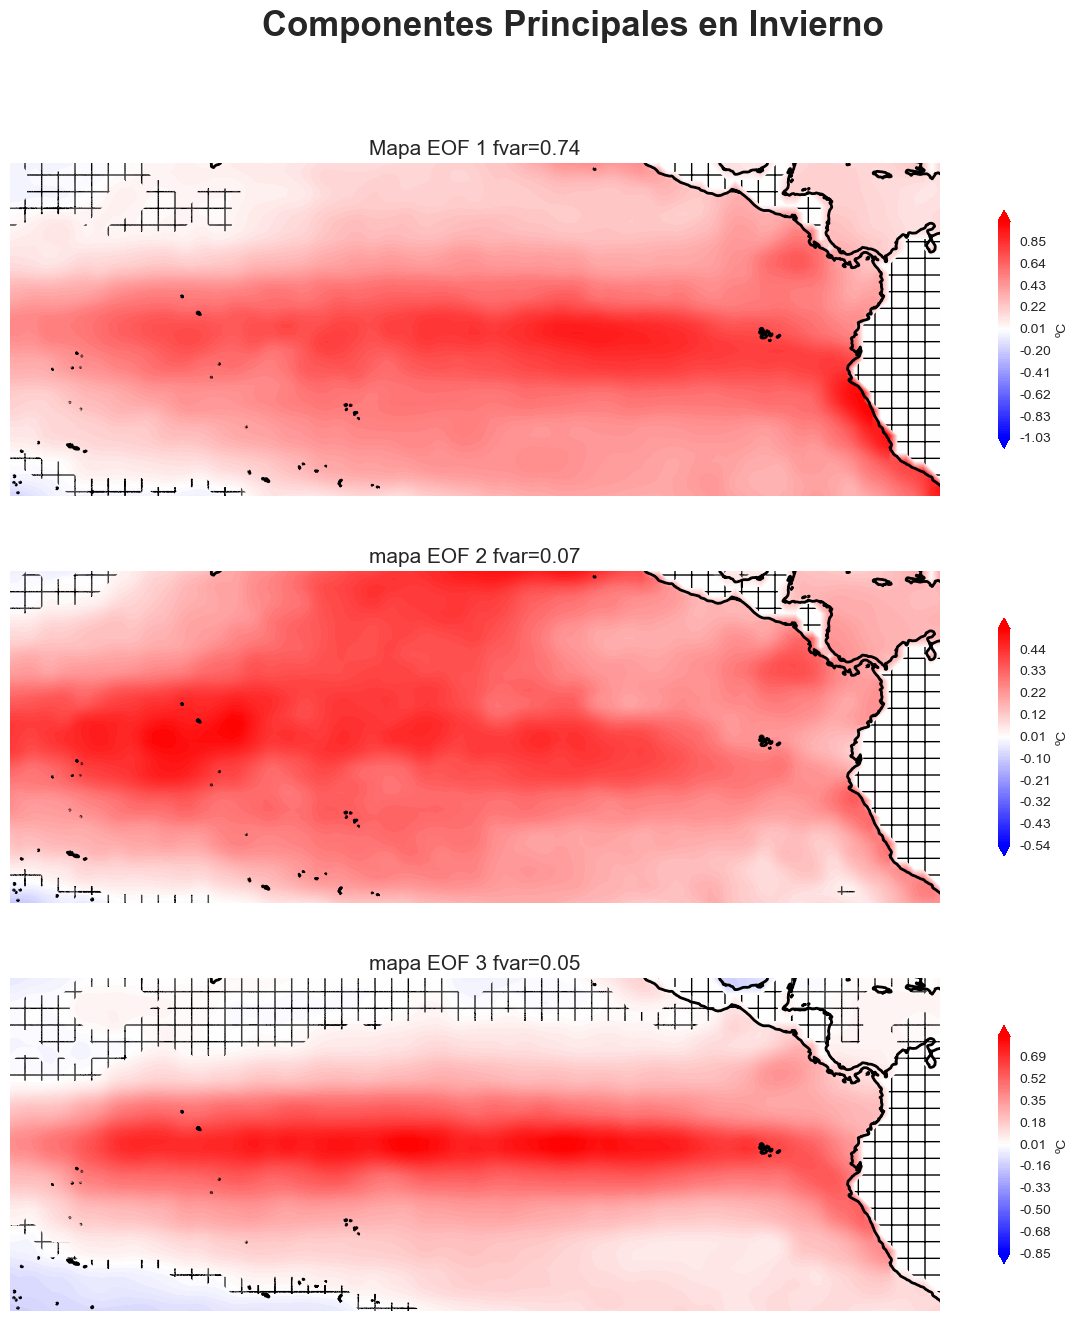

In [315]:
Cor_enso_inv, Cor_sig_enso_inv, Reg_enso_inv, Reg_sig_enso_inv, PCs_enso_inv, fvar_enso_inv, fig_enso_inv= componentes_principales(SST,'Invierno',11,1,'ºC',lat_enso,lon_enso)

### Primavera

(150, 4)


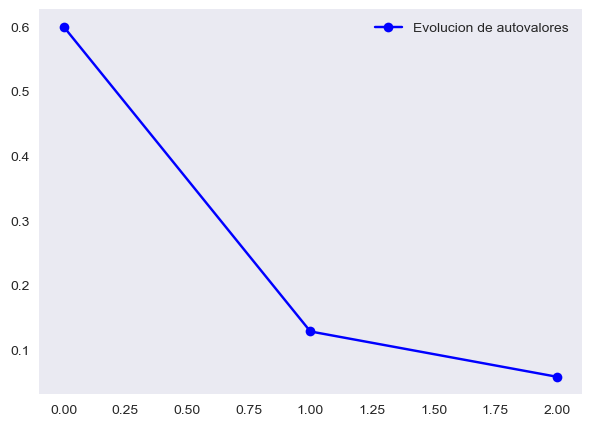

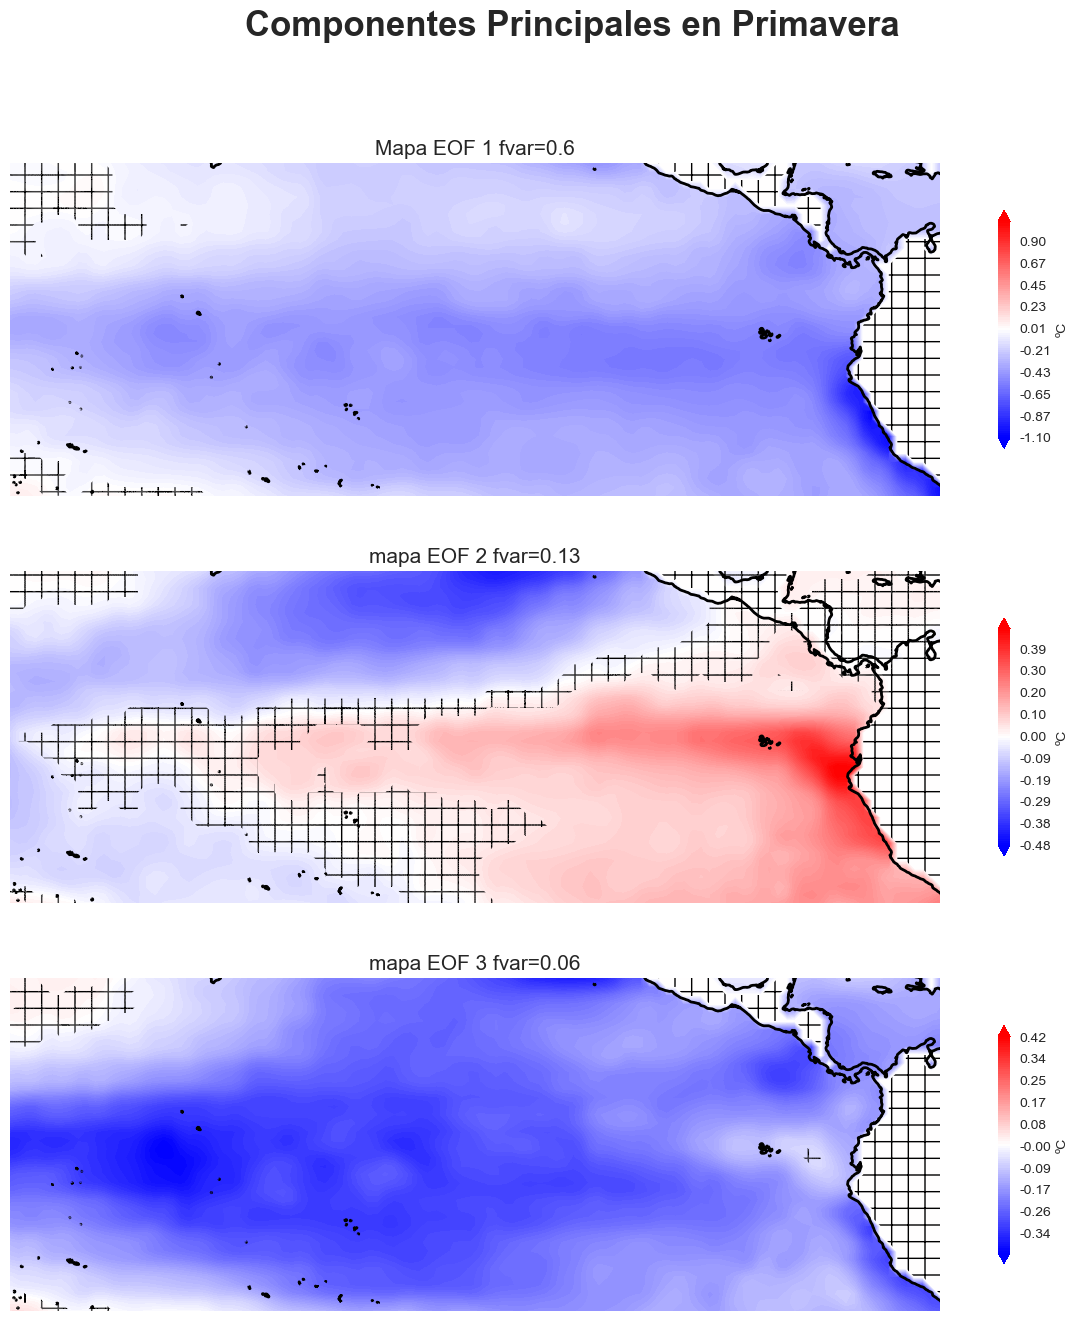

In [305]:
Cor_enso_pri, Cor_sig_enso_pri, Reg_enso_pri, Reg_sig_enso_pri, PCs_enso_pri, fvar_enso_pri, fig_enso_pri= componentes_principales(SST,'Primavera',2,4,'ºC',lat_enso,lon_enso)

### Verano

(150, 4)


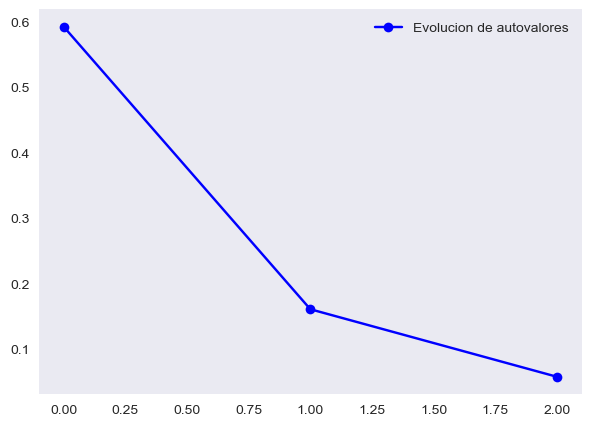

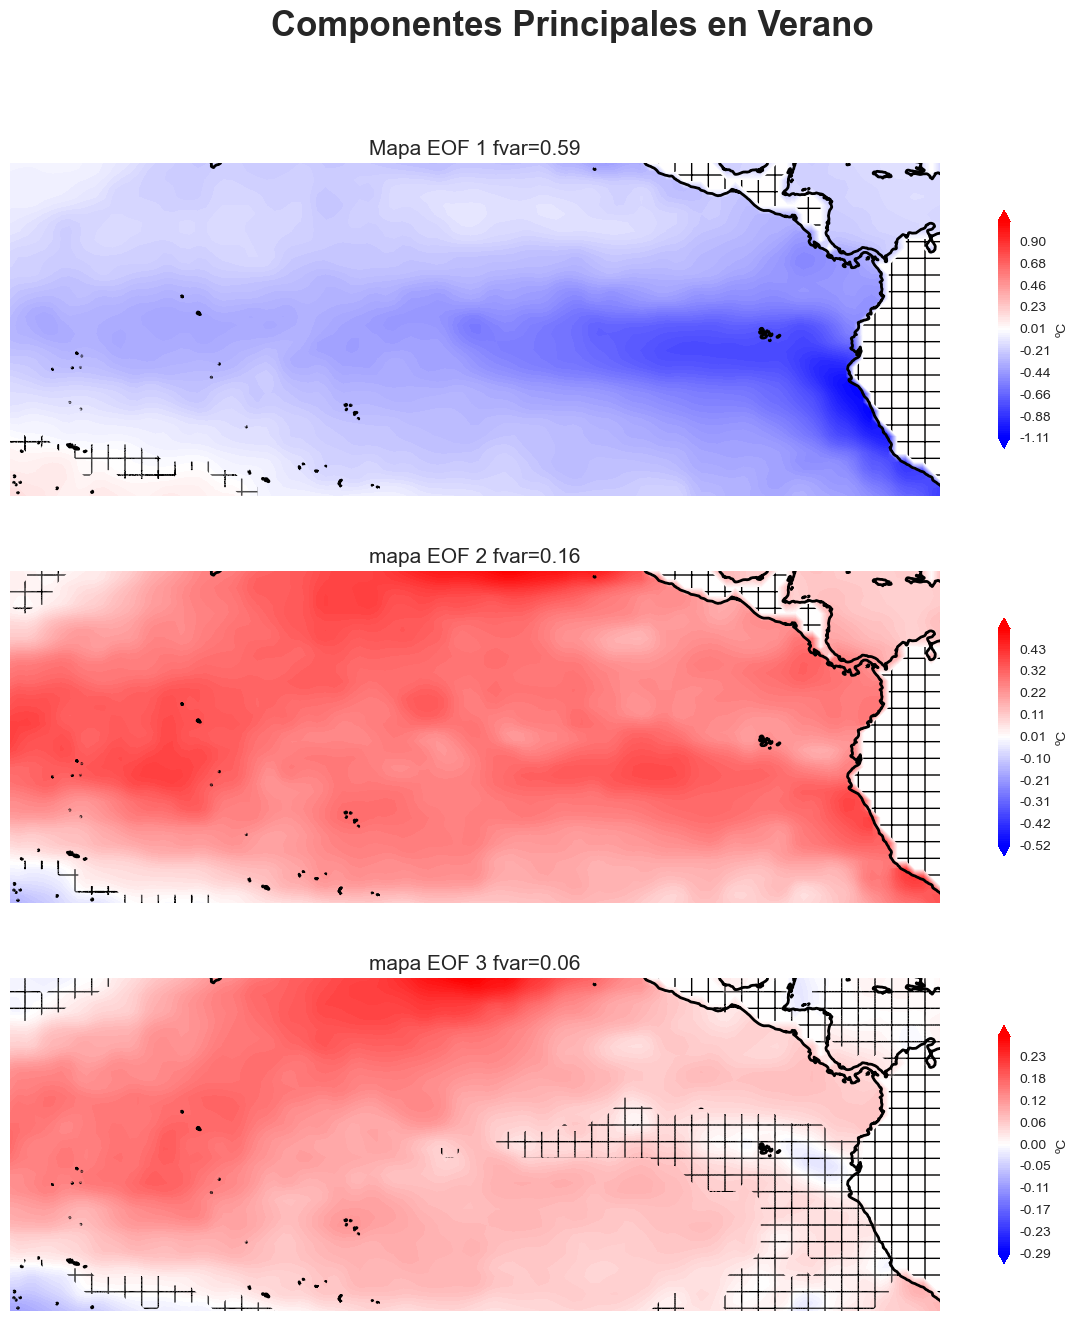

In [306]:
Cor_enso_ver, Cor_sig_enso_ver, Reg_enso_ver, Reg_sig_enso_ver, PCs_enso_ver, fvar_enso_ver, fig_enso_ver= componentes_principales(SST,'Verano',5,7,'ºC',lat_enso,lon_enso)

### Otoño

(150, 4)


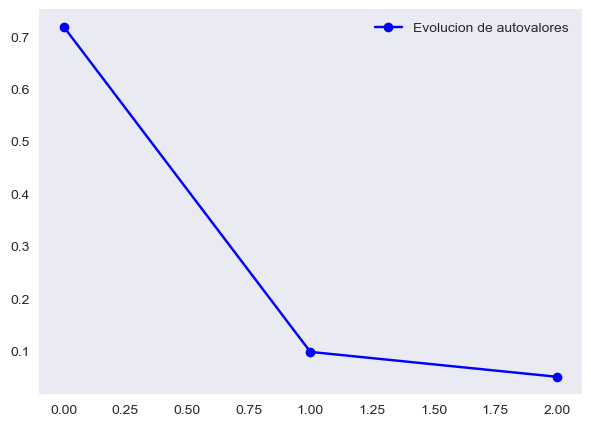

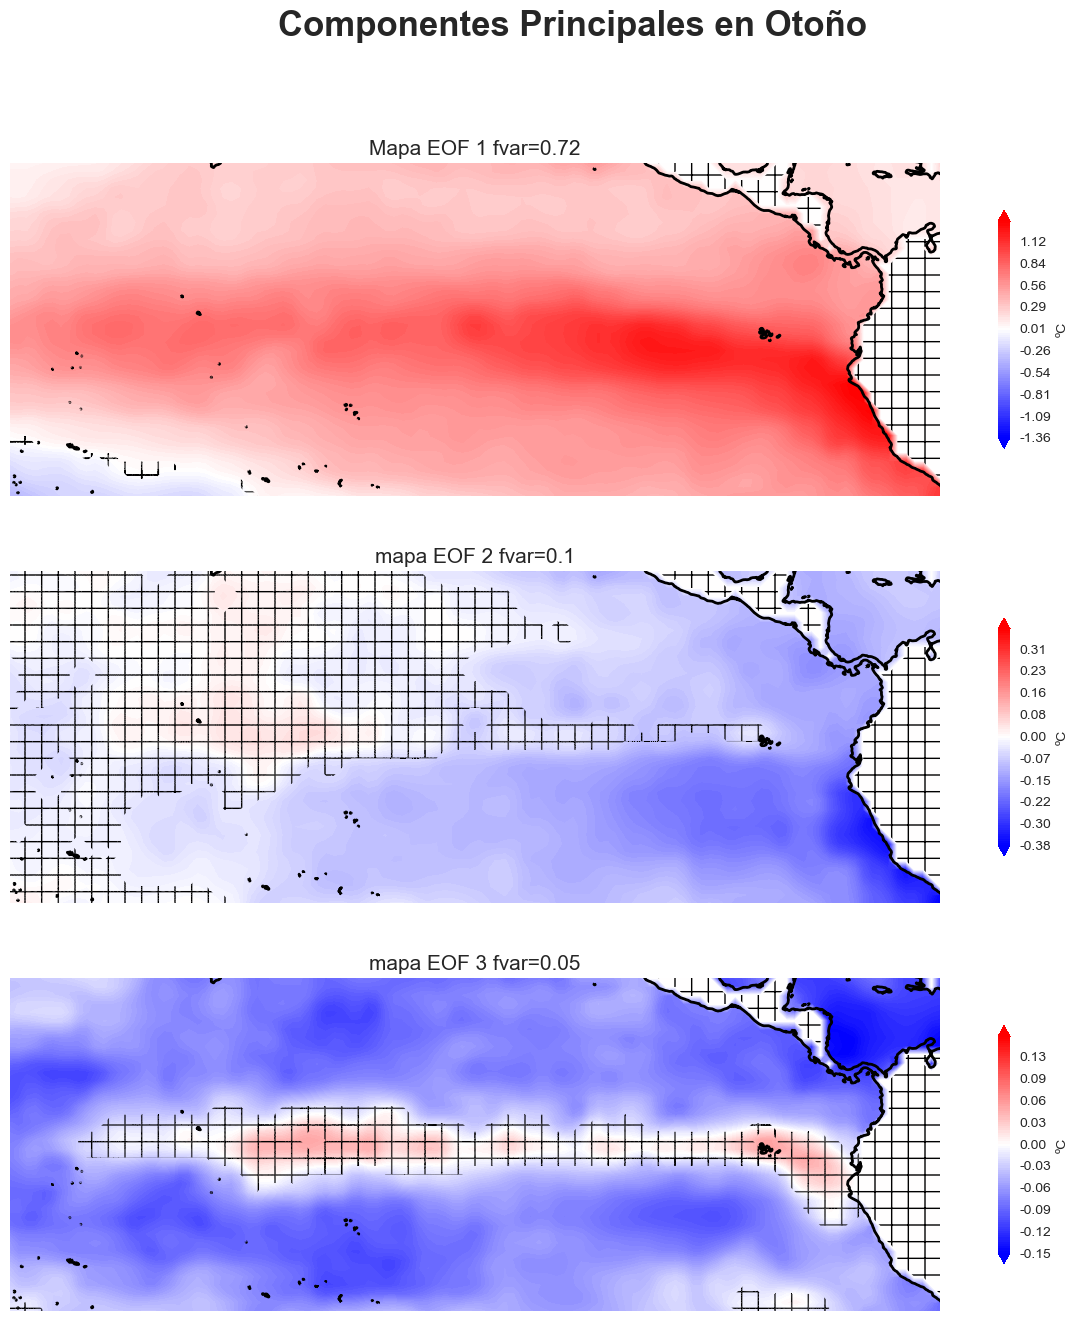

In [307]:
Cor_enso_oto, Cor_sig_enso_oto, Reg_enso_oto, Reg_sig_enso_oto, PCs_enso_oto, fvar_enso_oto, fig_enso_oto= componentes_principales(SST,'Otoño',8,10,'ºC',lat_enso,lon_enso)

### NAO

In [311]:
fil_nao= slp_file.copy()/100 #para pasarlo a hPa
lon_nao = fil_nao.longitude
lat_nao = fil_nao.latitude
msl_nao = fil_nao.msl
nt_nao, nlat_nao, nlon_nao = msl_nao.shape
nm_nao = 12
nyearsmsl_nao = int(nt_nao/nm_nao)

lonmin,lonmax,latmin,latmax = 260, 360, 10, 75
MSL,lat_nao,lon_nao=region(msl_nao,lat_nao,lon_nao,lonmin,lonmax,latmin,latmax)
yrsmsl_nao=np.linspace(1900,2010,111)
MSL=MSL[:111*12,:,:]
MSL=np.array(MSL)
# reorganizo los datos para que estén en numero de años, numero de meses y espacio
MSL=np.reshape(MSL, (len(yrsmsl_nao),12,len(lon_nao)*len(lat_nao)))
MSL.shape

(111, 12, 6600)

### Invierno

(110, 4)


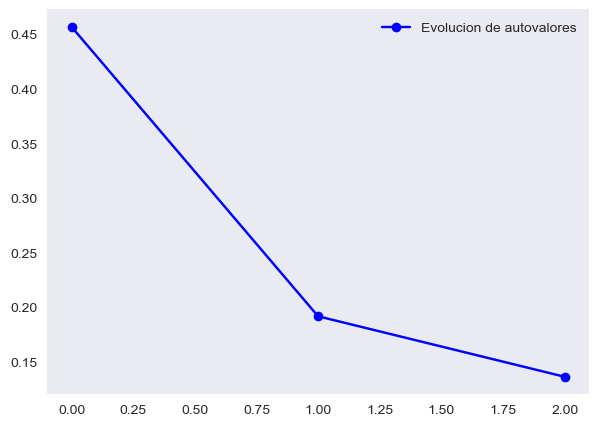

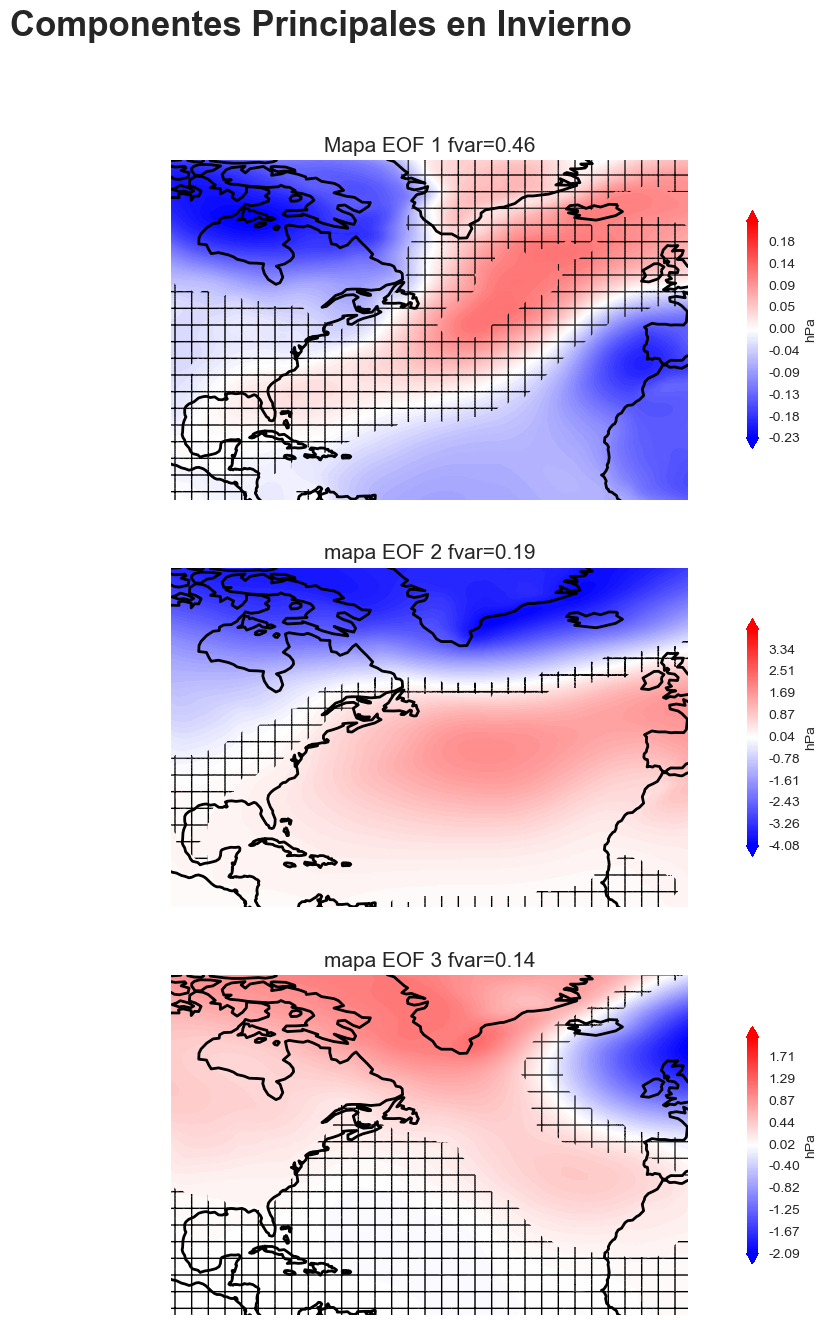

In [316]:
Cor_nao_inv, Cor_sig_nao_inv, Reg_nao_inv, Reg_sig_nao_inv, PCs_nao_inv, fvar_nao_inv, fig_nao_inv= componentes_principales(MSL,'Invierno',11,1,'hPa',lat_nao,lon_nao)

### Primavera

(111, 4)


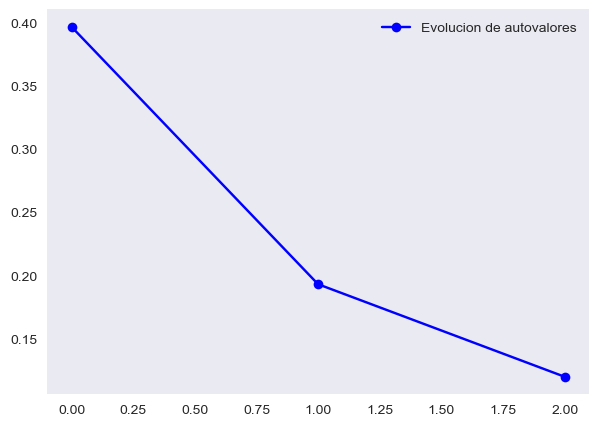

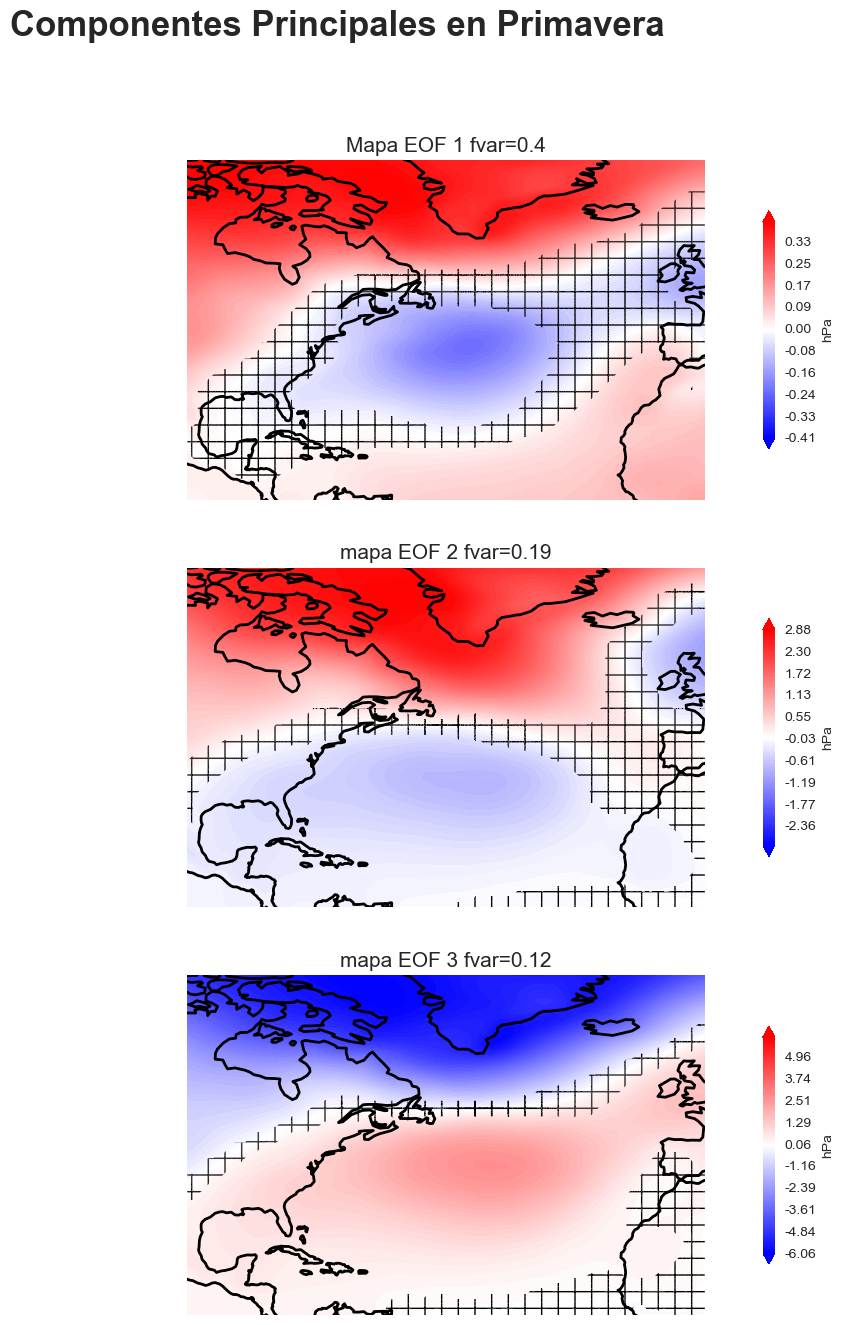

In [317]:
Cor_nao_pri, Cor_sig_nao_pri, Reg_nao_pri, Reg_sig_nao_pri, PCs_nao_pri, fvar_nao_pri, fig_nao_pri= componentes_principales(MSL,'Primavera',2,4,'hPa',lat_nao,lon_nao)

### Verano

(111, 4)


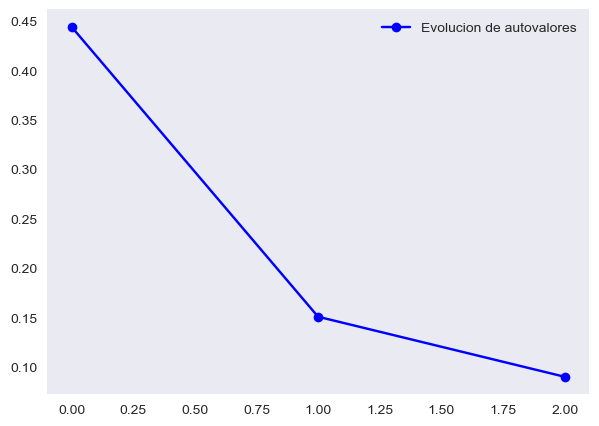

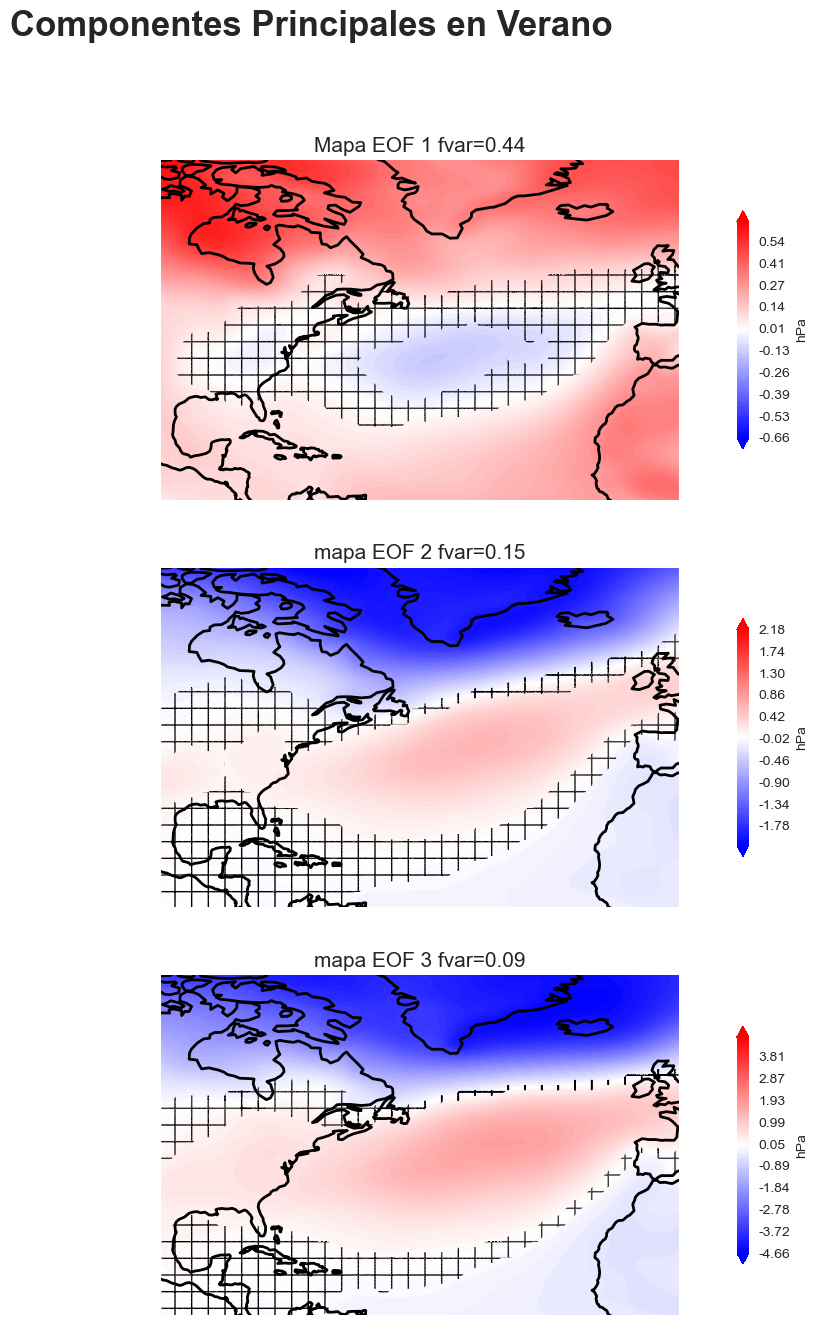

In [318]:
Cor_nao_ver, Cor_sig_nao_ver, Reg_nao_ver, Reg_sig_nao_ver, PCs_nao_ver, fvar_nao_ver, fig_nao_ver= componentes_principales(MSL,'Verano',5,7,'hPa',lat_nao,lon_nao)

### Otoño

(111, 4)


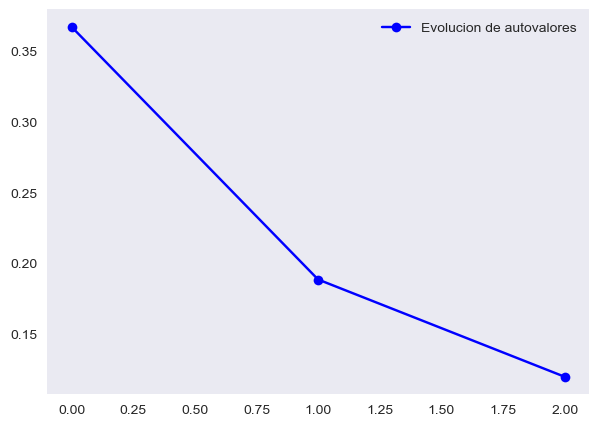

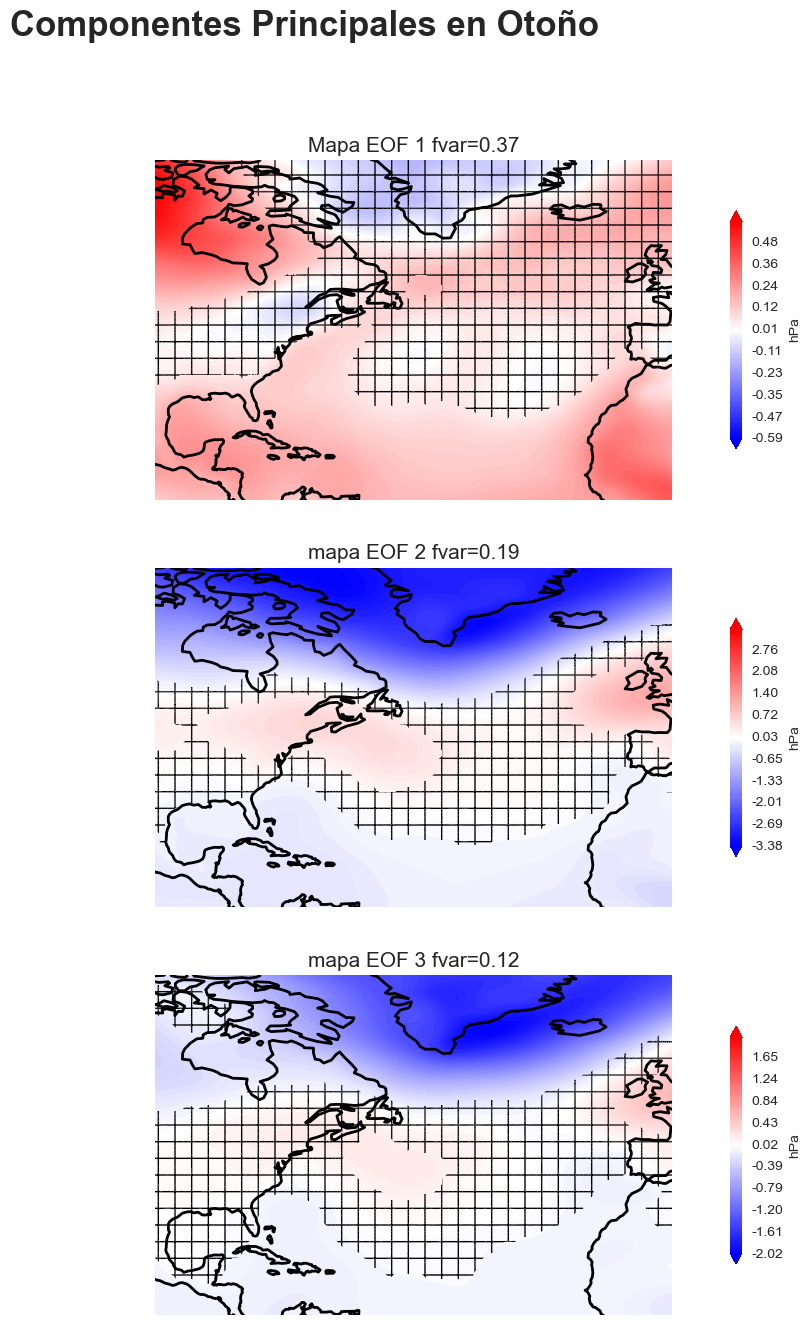

In [319]:
Cor_nao_oto, Cor_sig_nao_oto, Reg_nao_oto, Reg_sig_nao_oto, PCs_nao_oto, fvar_nao_oto, fig_nao_oto= componentes_principales(MSL,'Otoño',8,10,'hPa',lat_nao,lon_nao)

Una vez tenemos las EOFs y las PCs, procedemos a calcular la relación entre éstas y los índices que calculamos antes. Para ello vamos a calcular los mapas de correlación, para ello correlacionamos los índices con las EOFs

# Relación entre EOFs e Índices (Correlación):
## A. ENSO y Niño3

In [320]:
def regresLinSim(x,y,titulo):
    alpha = 0.05
    x = np.squeeze(np.array(x))
    y = np.squeeze(np.array(y))
    N = x.size
    xm = x.mean()
    ym = y.mean()
    SXY = np.sum(x * y) - N * xm * ym
    SXX = np.sum(x * x) - N * xm * xm
    SYY = np.sum(y * y) - N * ym * ym
    SSR = SXY ** 2 / SXX 
    a1 = SXY / SXX
    a0 = ym - xm * a1
    yhat =  a0 + a1 * x
    e = y - yhat
    R2 = SSR / SYY
    SSE = SYY - SSR
    rho = SXY / np.sqrt(SXX*SYY)
    Se = np.sqrt( SSE / (N - 2 ) )
    t = stats.t.ppf(1-alpha/2,N-2)
    IC_a1 = a1 + np.array([-1, 1]) * t * Se / np.sqrt(SXX)
    IC_a0 = a0 + np.array([-1, 1]) * t * Se * np.sqrt(np.sum(x*x)/N/SXX)
    xvec = np.linspace(x.min(),x.max(),100)
    muY = ym + a1 * (xvec - xm) 
    AmuY = t * Se * np.sqrt(1/N + (xvec-xm) * (xvec -xm) /SXX)
    AY = t * Se * np.sqrt( 1 + 1/N + (xvec-xm) * (xvec -xm) /SXX)
    fig,ax = plt.subplots(1,2,figsize=(16,6))
    ax[0].plot(x,y,'.')
    ax[0].grid()
    ax[0].plot(xvec,muY+AmuY,color='orange')
    ax[0].plot(xvec,muY-AmuY,color='orange')
    ax[0].plot([x.min(), x.max()],[a0+a1*x.min(), a0+a1*x.max()],'r')
    ax[0].plot(xvec,muY+AY,color='k')
    ax[0].plot(xvec,muY-AY,color='k')
    ax[0].set_title('Simple Linear Regression')
    ax[0].set_ylabel('y')
    ax[0].set_xlabel('x')
    ax[0].text(0.5,0.05,'a0=[%.3f,%.3f]'%(IC_a0[0],IC_a0[1]), transform=ax[0].transAxes)
    ax[0].text(0.5,0.1,'a1=[%.3f,%.3f]'%(IC_a1[0],IC_a1[1]), transform=ax[0].transAxes)
    ax[0].text(0.5,0.15,'rho=%.2f'%(rho), transform=ax[0].transAxes)
    ax[1].plot(yhat,e/Se,'.')
    ax[1].grid()
    ax[1].set_xlabel(r'$\hat{y}$')
    ax[1].set_ylabel(r'$\hat{e}/\sigma_E$')
    ax[1].set_title('Standardized residuals')
    fig.suptitle(titulo,size=15,weight='bold')
    return a1, a0, rho, IC_a1, IC_a0, muY, AmuY, AY

## Invierno

In [321]:
ANOMALIA_nino_3_djf= ((nino_3.groupby('time.season')-nino_3.groupby('time.season').mean('time'))).groupby('time.season')/nino_3.groupby('time.season').std('time')
ANOMALIA_nino_3_djf= (ANOMALIA_nino_3_djf.groupby('time.season')['DJF']).groupby('time.year').mean()[0:-1]
ANOMALIA_nino_3_djf.shape

(149,)

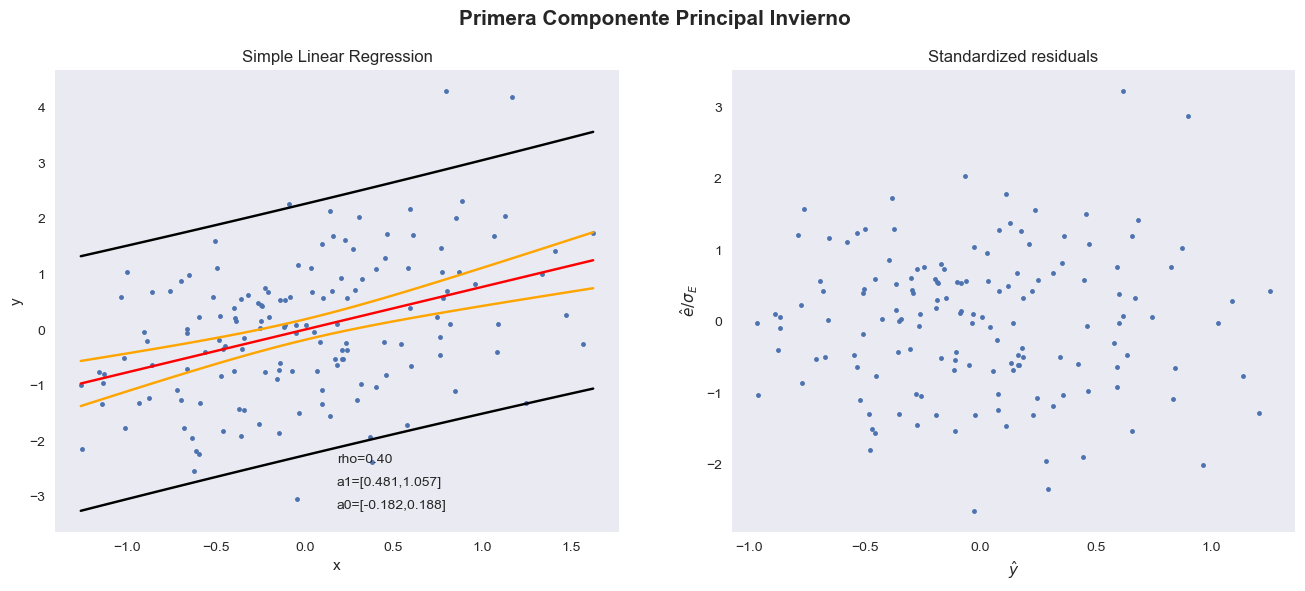

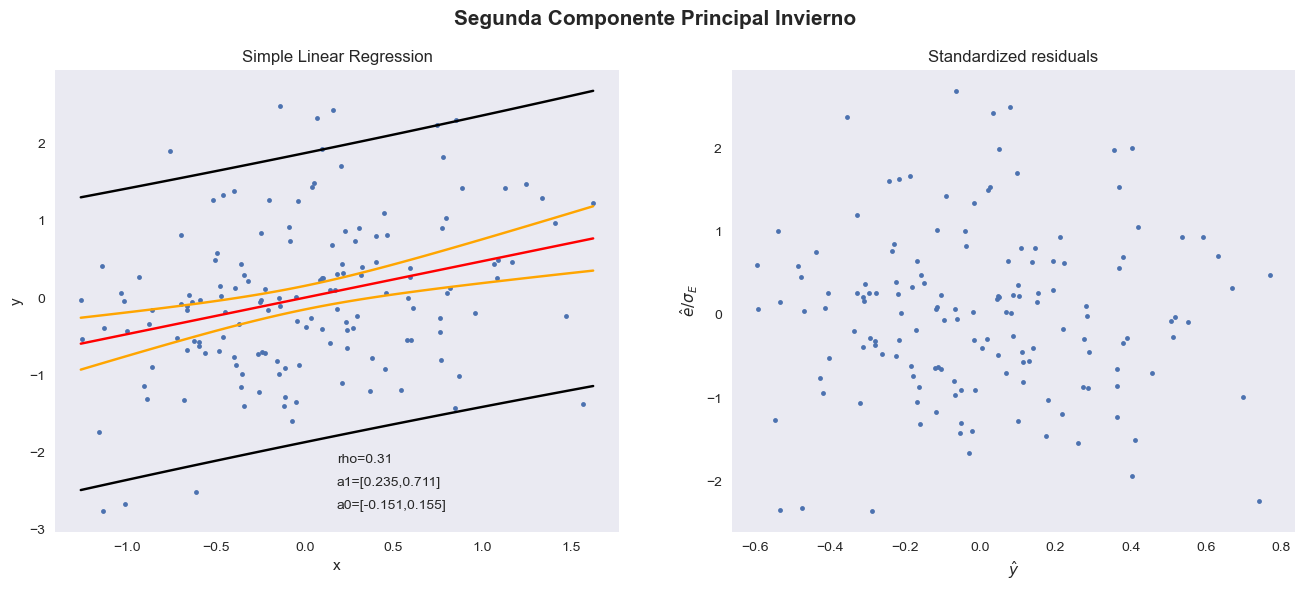

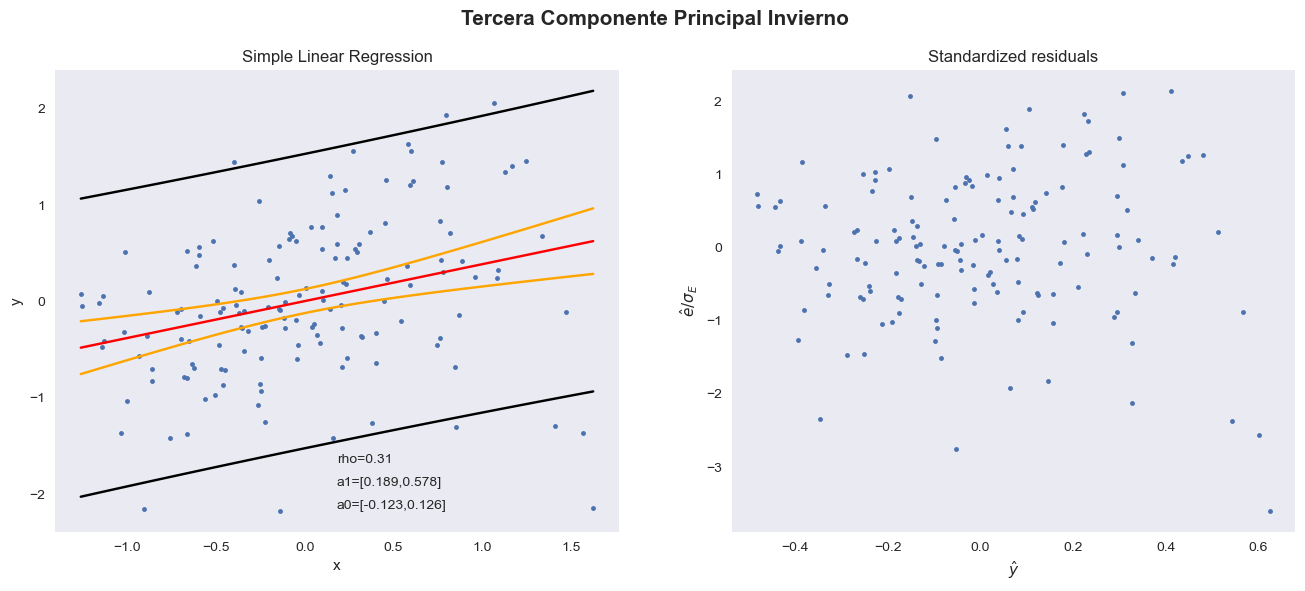

In [322]:
a1, a0, rho, IC_a1, IC_a0, muY, AmuY, AY = regresLinSim(ANOMALIA_nino_3_djf,PCs_enso_inv[:,0],'Primera Componente Principal Invierno')
a1, a0, rho, IC_a1, IC_a0, muY, AmuY, AY = regresLinSim(ANOMALIA_nino_3_djf,PCs_enso_inv[:,1],'Segunda Componente Principal Invierno')
a1, a0, rho, IC_a1, IC_a0, muY, AmuY, AY = regresLinSim(ANOMALIA_nino_3_djf,PCs_enso_inv[:,2],'Tercera Componente Principal Invierno')

### Primavera

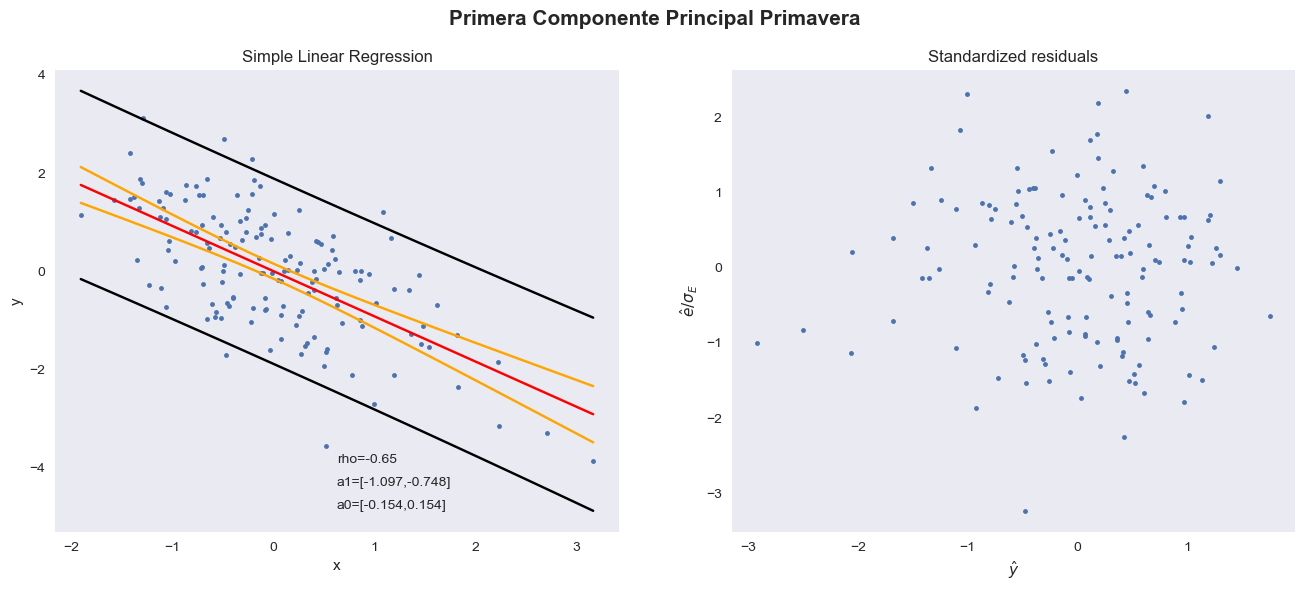

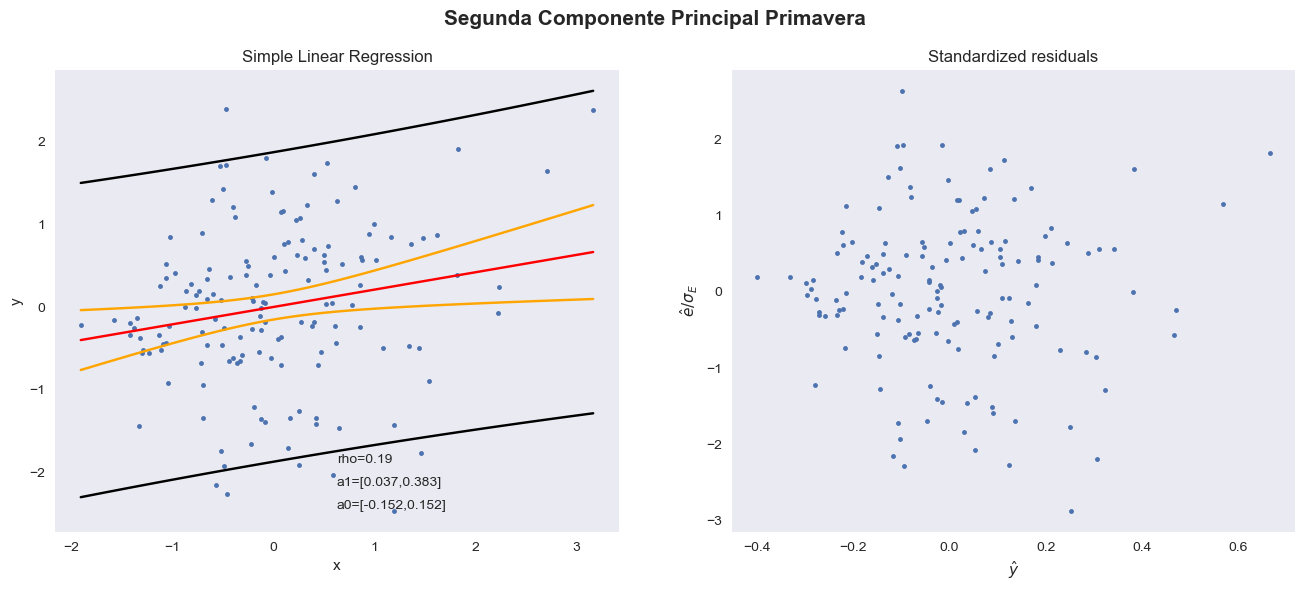

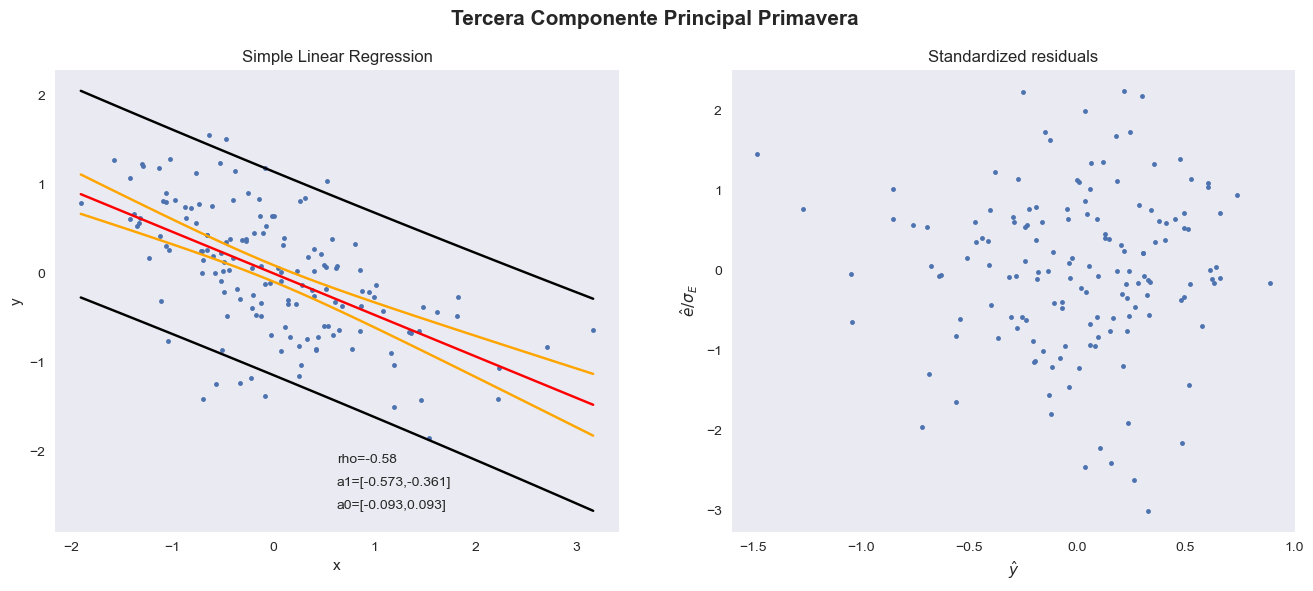

In [323]:
ANOMALIA_nino_3_mam= ((nino_3.groupby('time.season')-nino_3.groupby('time.season').mean('time'))).groupby('time.season')/nino_3.groupby('time.season').std('time')
ANOMALIA_nino_3_mam= (ANOMALIA_nino_3_mam.groupby('time.season')['MAM']).groupby('time.year').mean()
a1, a0, rho, IC_a1, IC_a0, muY, AmuY, AY = regresLinSim(ANOMALIA_nino_3_mam,PCs_enso_pri[:,0],'Primera Componente Principal Primavera')
a1, a0, rho, IC_a1, IC_a0, muY, AmuY, AY = regresLinSim(ANOMALIA_nino_3_mam,PCs_enso_pri[:,1],'Segunda Componente Principal Primavera')
a1, a0, rho, IC_a1, IC_a0, muY, AmuY, AY = regresLinSim(ANOMALIA_nino_3_mam,PCs_enso_pri[:,2],'Tercera Componente Principal Primavera')

## Verano

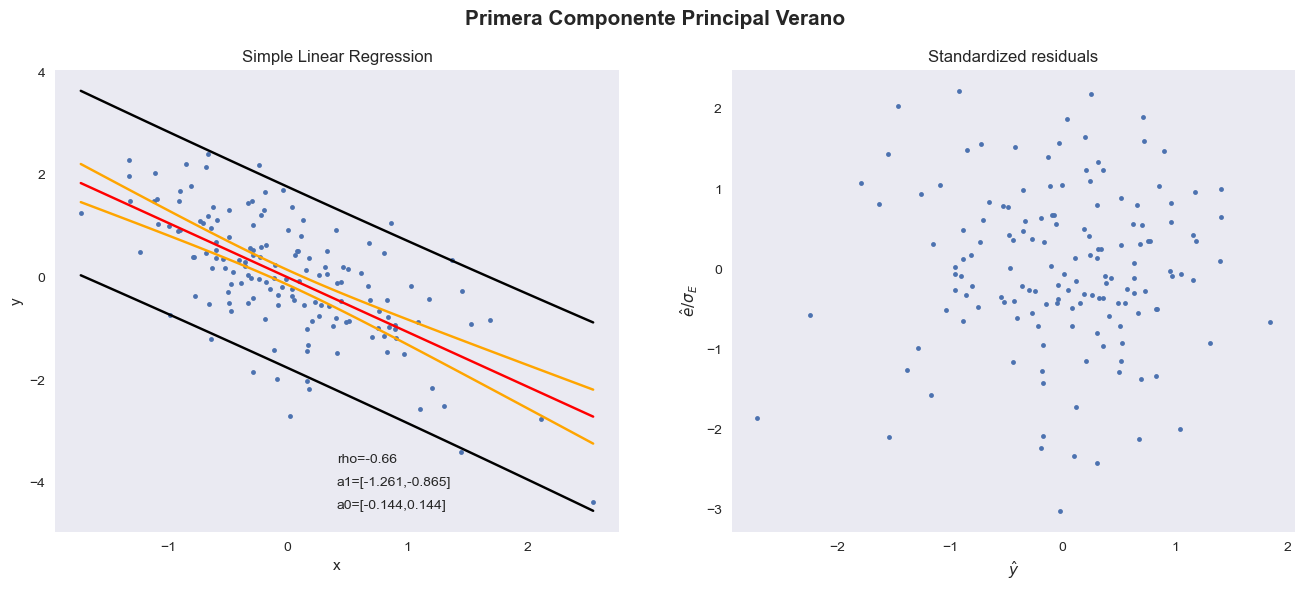

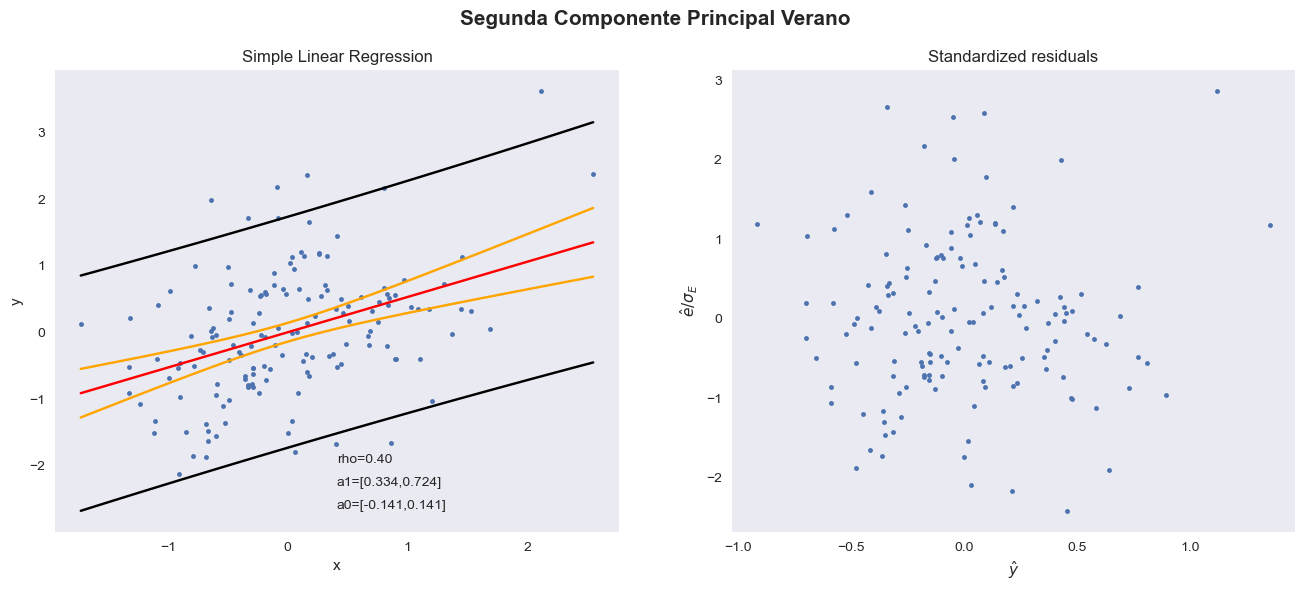

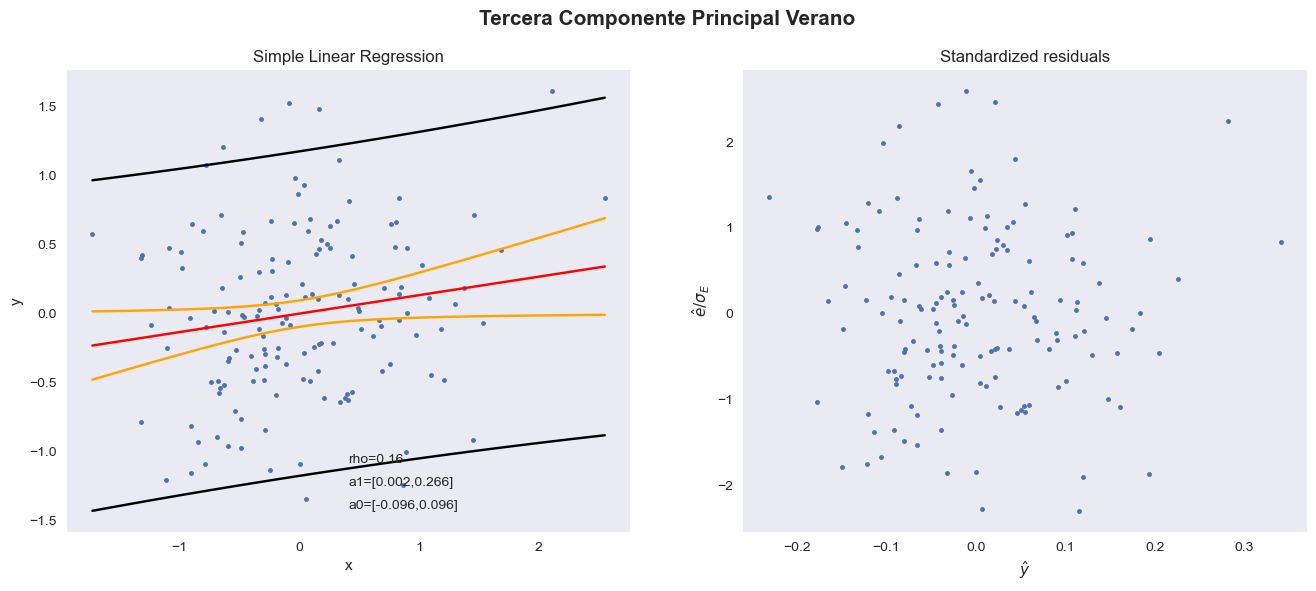

In [324]:
ANOMALIA_nino_3_jja= ((nino_3.groupby('time.season')-nino_3.groupby('time.season').mean('time'))).groupby('time.season')/nino_3.groupby('time.season').std('time')
ANOMALIA_nino_3_jja= (ANOMALIA_nino_3_jja.groupby('time.season')['JJA']).groupby('time.year').mean()
a1, a0, rho, IC_a1, IC_a0, muY, AmuY, AY = regresLinSim(ANOMALIA_nino_3_jja,PCs_enso_ver[:,0],'Primera Componente Principal Verano')
a1, a0, rho, IC_a1, IC_a0, muY, AmuY, AY = regresLinSim(ANOMALIA_nino_3_jja,PCs_enso_ver[:,1],'Segunda Componente Principal Verano')
a1, a0, rho, IC_a1, IC_a0, muY, AmuY, AY = regresLinSim(ANOMALIA_nino_3_jja,PCs_enso_ver[:,2],'Tercera Componente Principal Verano')

### Otoño

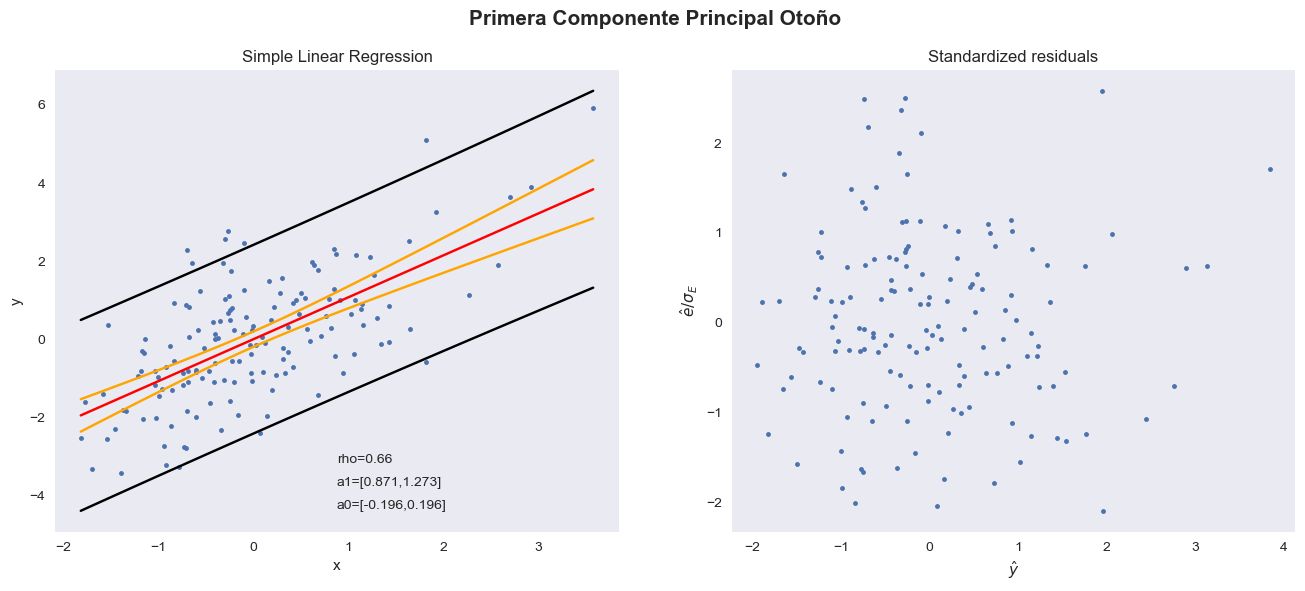

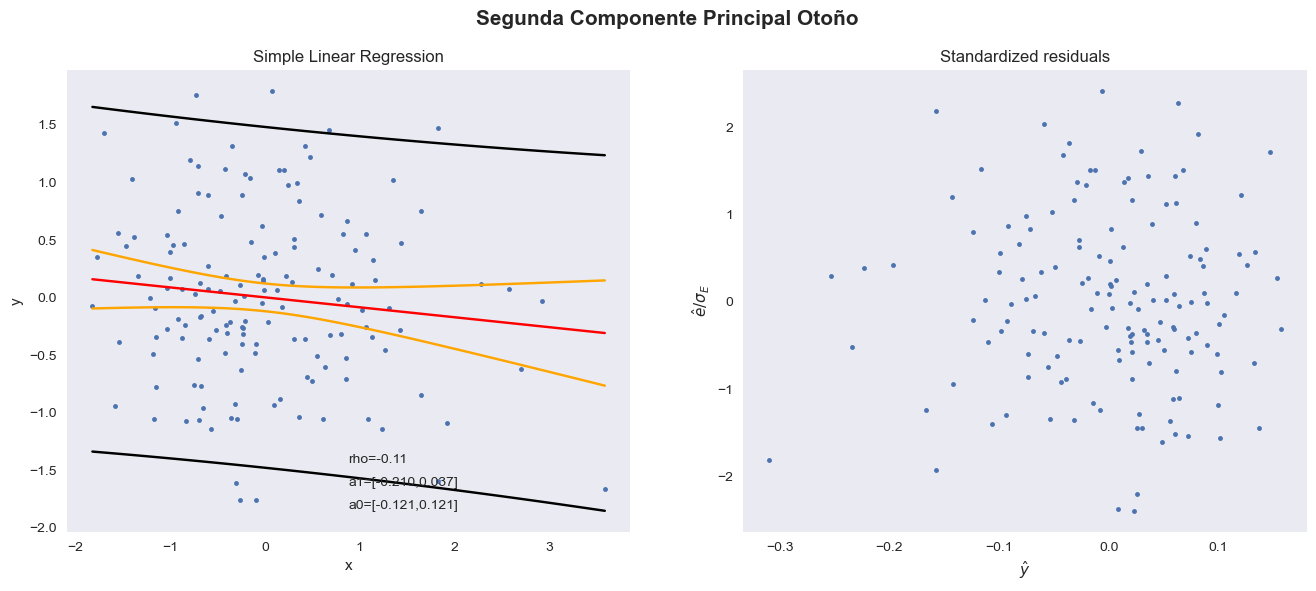

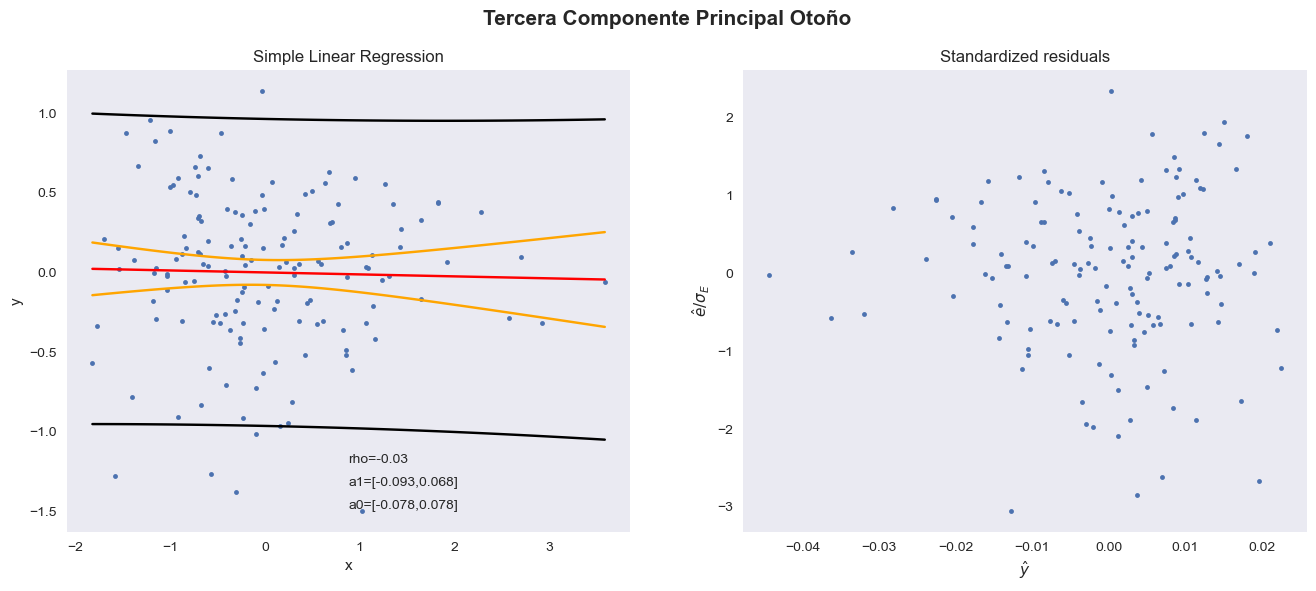

In [325]:
ANOMALIA_nino_3_son= ((nino_3.groupby('time.season')-nino_3.groupby('time.season').mean('time'))).groupby('time.season')/nino_3.groupby('time.season').std('time')
ANOMALIA_nino_3_son= (ANOMALIA_nino_3_son.groupby('time.season')['SON']).groupby('time.year').mean()
a1, a0, rho, IC_a1, IC_a0, muY, AmuY, AY = regresLinSim(ANOMALIA_nino_3_son,PCs_enso_oto[:,0],'Primera Componente Principal Otoño')
a1, a0, rho, IC_a1, IC_a0, muY, AmuY, AY = regresLinSim(ANOMALIA_nino_3_son,PCs_enso_oto[:,1],'Segunda Componente Principal Otoño')
a1, a0, rho, IC_a1, IC_a0, muY, AmuY, AY = regresLinSim(ANOMALIA_nino_3_son,PCs_enso_oto[:,2],'Tercera Componente Principal Otoño')

## B. SLP y NAO

### Invierno

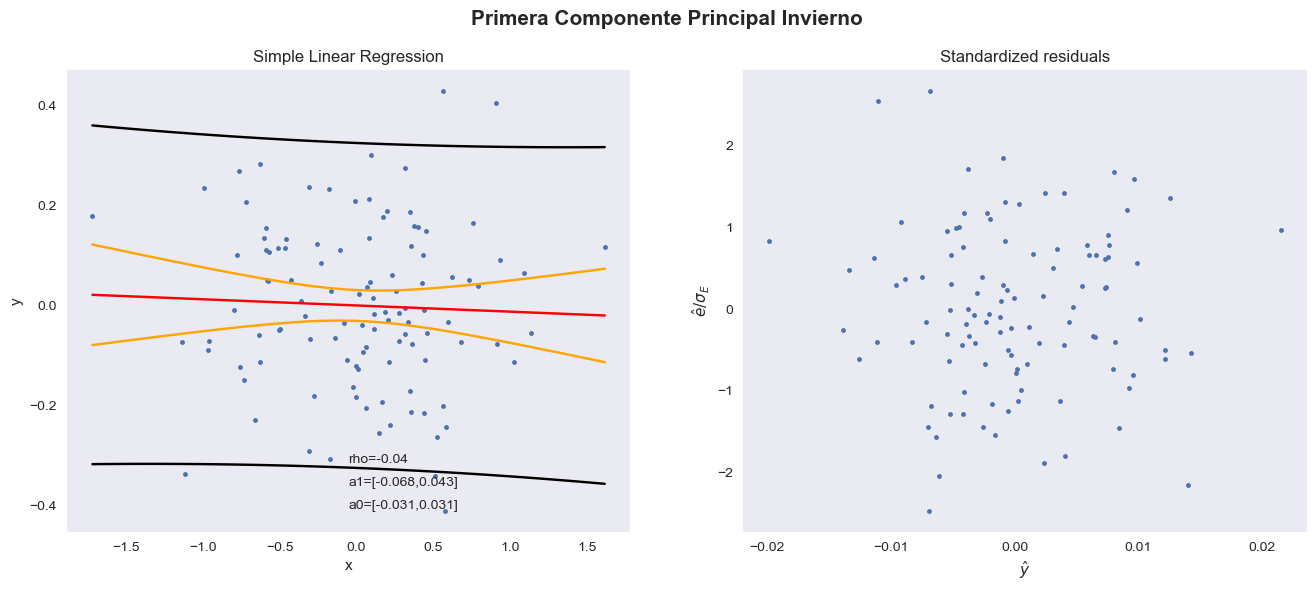

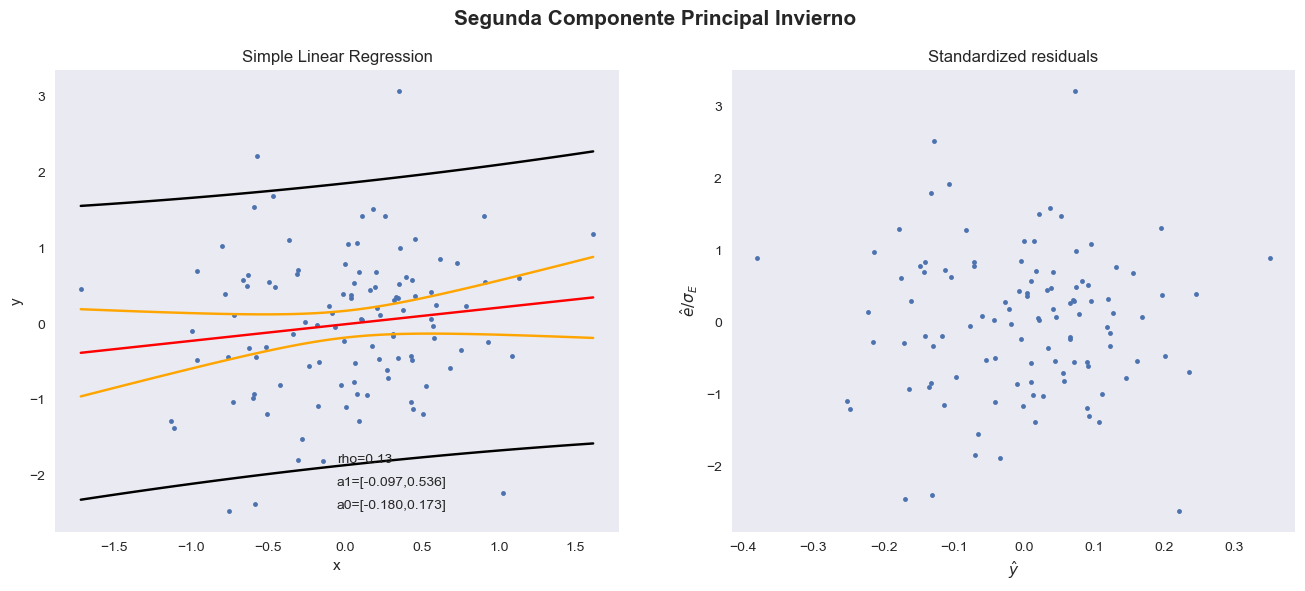

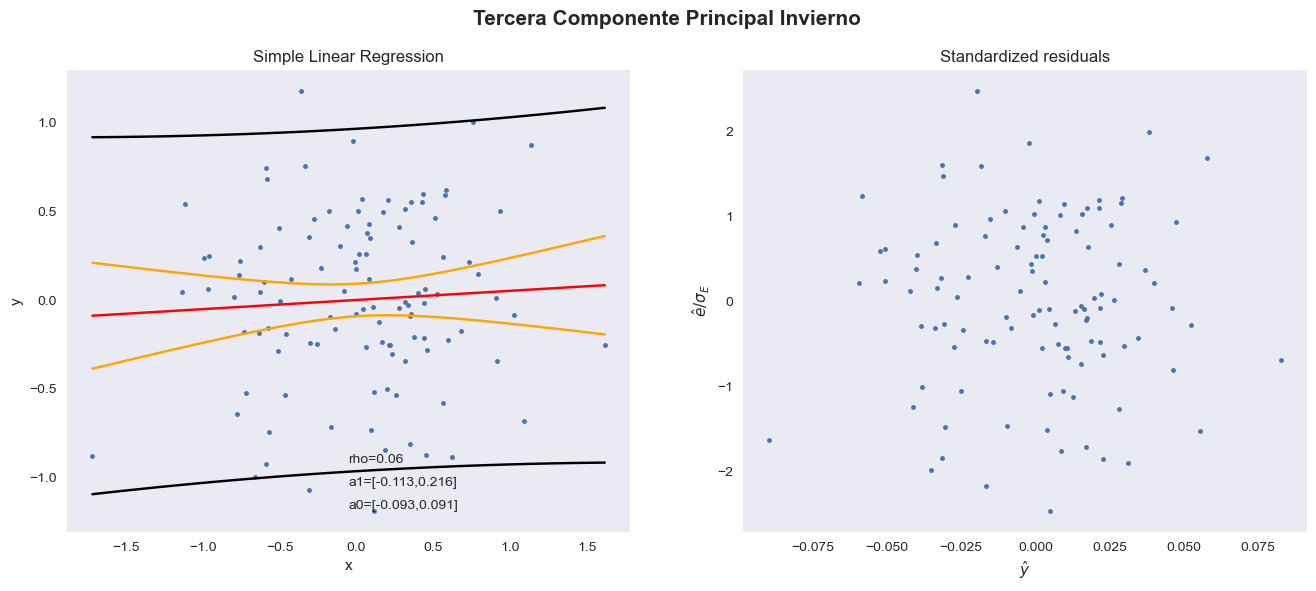

In [326]:
nao_djf= ((diferencia_presion.groupby('time.season')-diferencia_presion.groupby('time.season').mean('time'))).groupby('time.season')/diferencia_presion.groupby('time.season').std('time')
nao_djf= (nao_djf.groupby('time.season')['DJF']).groupby('time.year').mean()[:-1]
a1, a0, rho, IC_a1, IC_a0, muY, AmuY, AY = regresLinSim(nao_djf,PCs_nao_inv[:,0],'Primera Componente Principal Invierno')
a1, a0, rho, IC_a1, IC_a0, muY, AmuY, AY = regresLinSim(nao_djf,PCs_nao_inv[:,1],'Segunda Componente Principal Invierno')
a1, a0, rho, IC_a1, IC_a0, muY, AmuY, AY = regresLinSim(nao_djf,PCs_nao_inv[:,2],'Tercera Componente Principal Invierno')

### Primavera

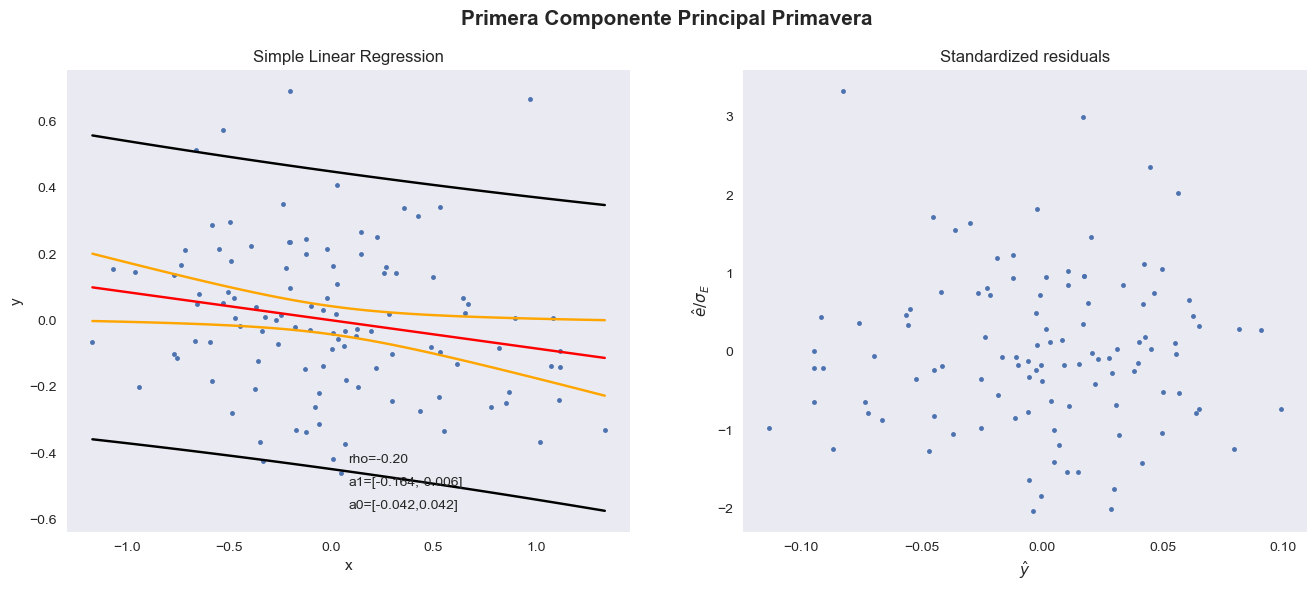

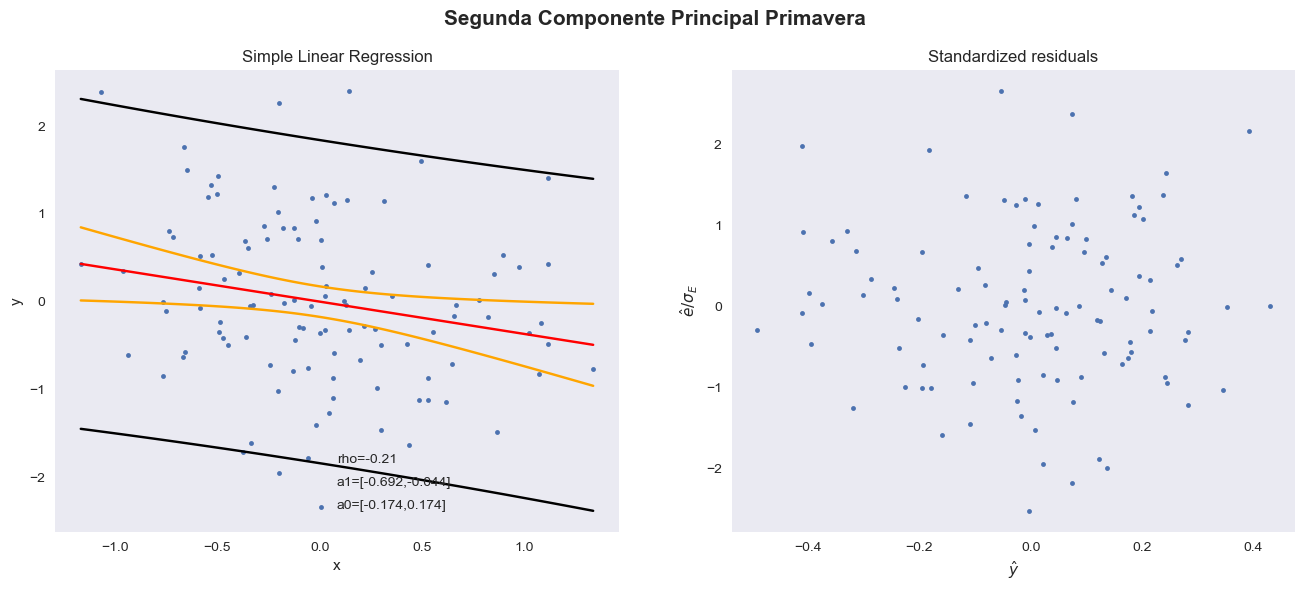

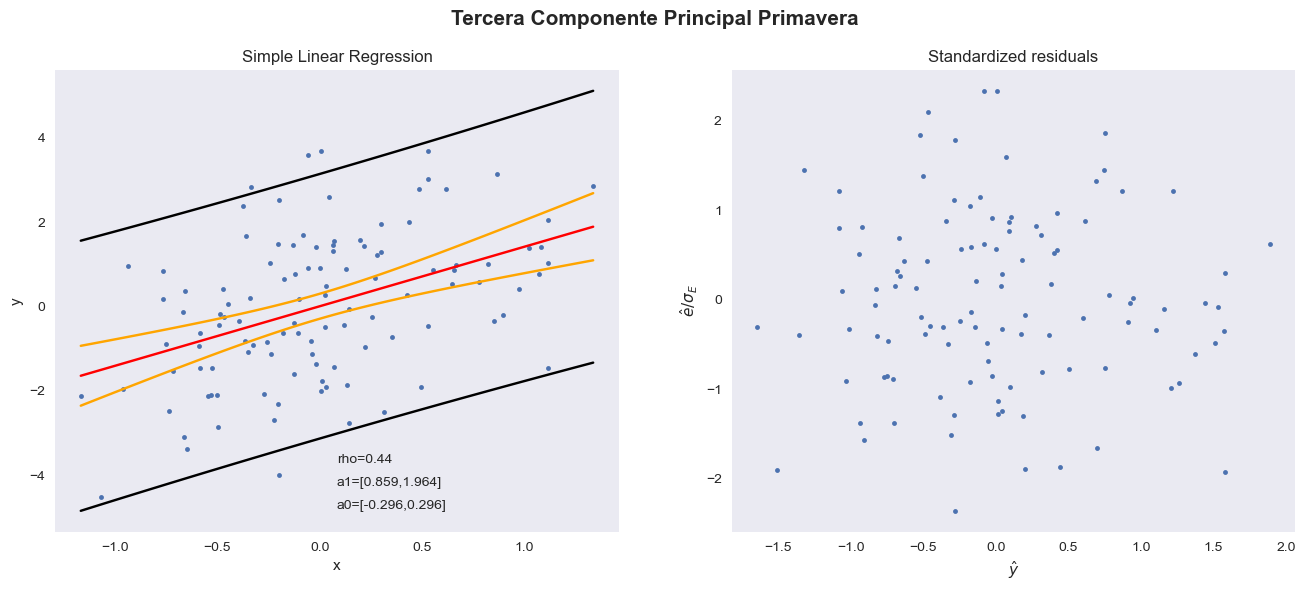

In [327]:
nao_mam= ((diferencia_presion.groupby('time.season')-diferencia_presion.groupby('time.season').mean('time'))).groupby('time.season')/diferencia_presion.groupby('time.season').std('time')
nao_mam= (nao_mam.groupby('time.season')['MAM']).groupby('time.year').mean()
a1, a0, rho, IC_a1, IC_a0, muY, AmuY, AY = regresLinSim(nao_mam,PCs_nao_pri[:,0],'Primera Componente Principal Primavera')
a1, a0, rho, IC_a1, IC_a0, muY, AmuY, AY = regresLinSim(nao_mam,PCs_nao_pri[:,1],'Segunda Componente Principal Primavera')
a1, a0, rho, IC_a1, IC_a0, muY, AmuY, AY = regresLinSim(nao_mam,PCs_nao_pri[:,2],'Tercera Componente Principal Primavera')

### Verano

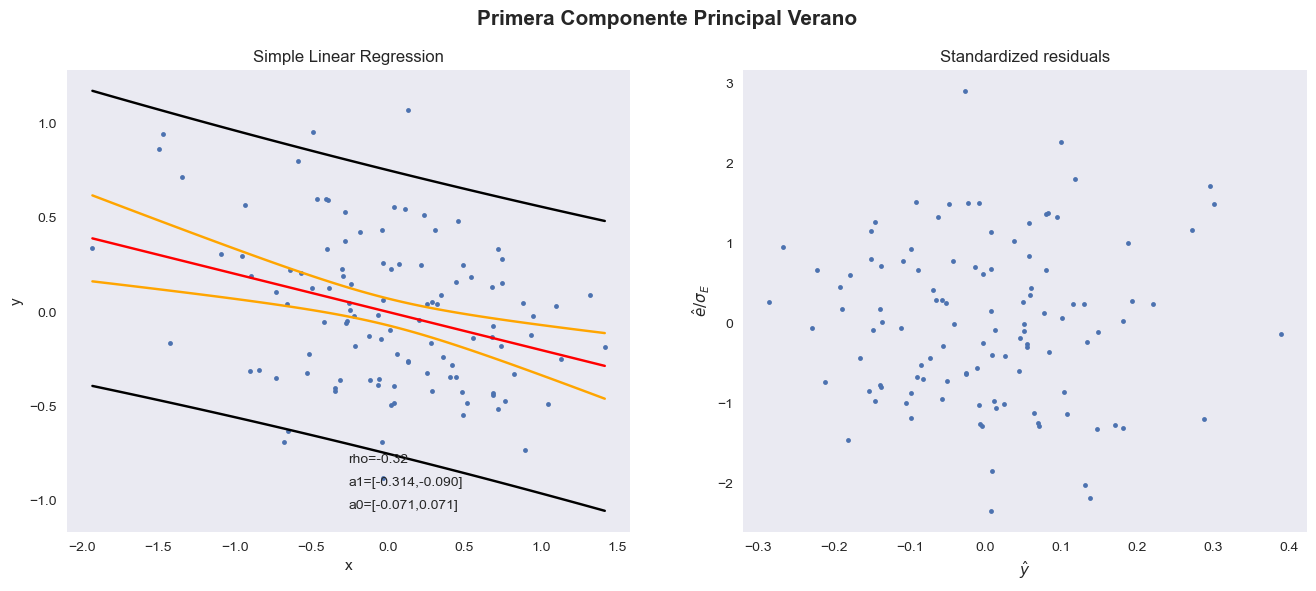

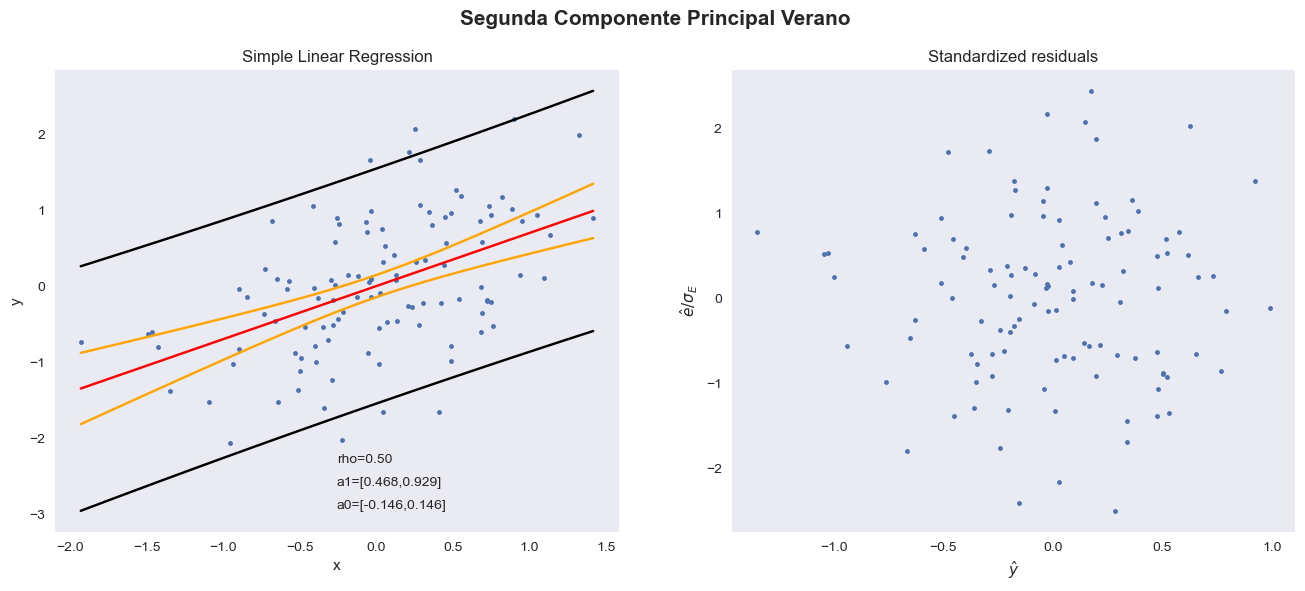

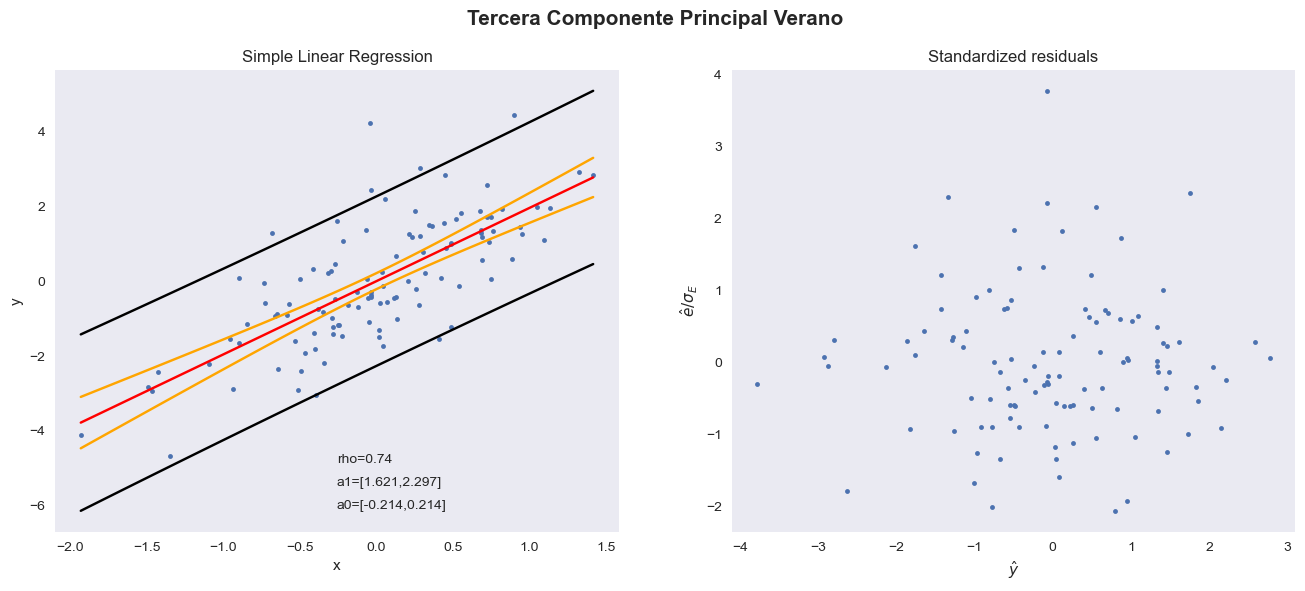

In [328]:
nao_jja= ((diferencia_presion.groupby('time.season')-diferencia_presion.groupby('time.season').mean('time'))).groupby('time.season')/diferencia_presion.groupby('time.season').std('time')
nao_jja= (nao_jja.groupby('time.season')['JJA']).groupby('time.year').mean()
a1, a0, rho, IC_a1, IC_a0, muY, AmuY, AY = regresLinSim(nao_jja,PCs_nao_ver[:,0],'Primera Componente Principal Verano')
a1, a0, rho, IC_a1, IC_a0, muY, AmuY, AY = regresLinSim(nao_jja,PCs_nao_ver[:,1],'Segunda Componente Principal Verano')
a1, a0, rho, IC_a1, IC_a0, muY, AmuY, AY = regresLinSim(nao_jja,PCs_nao_ver[:,2],'Tercera Componente Principal Verano')

### Otoño

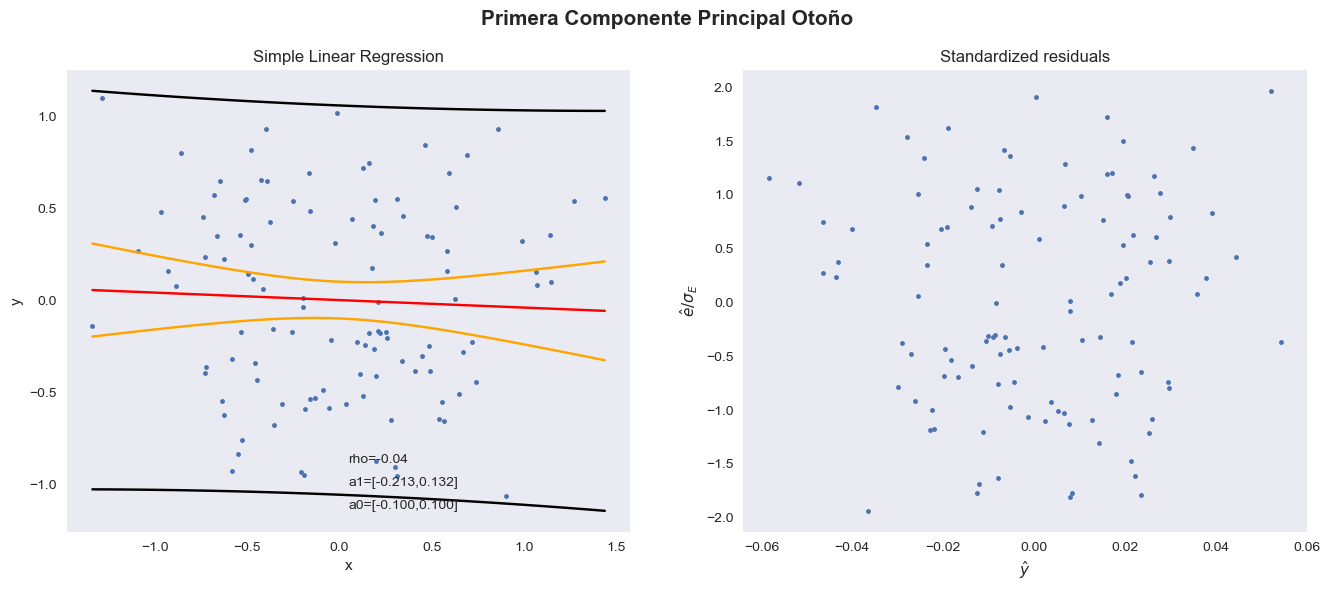

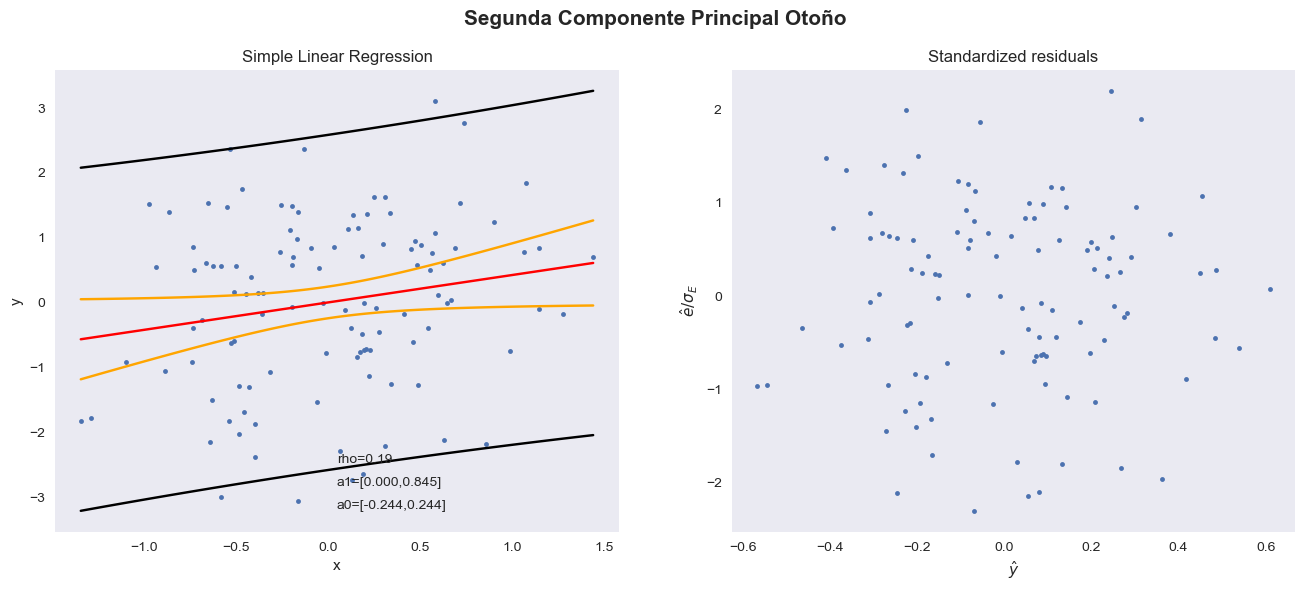

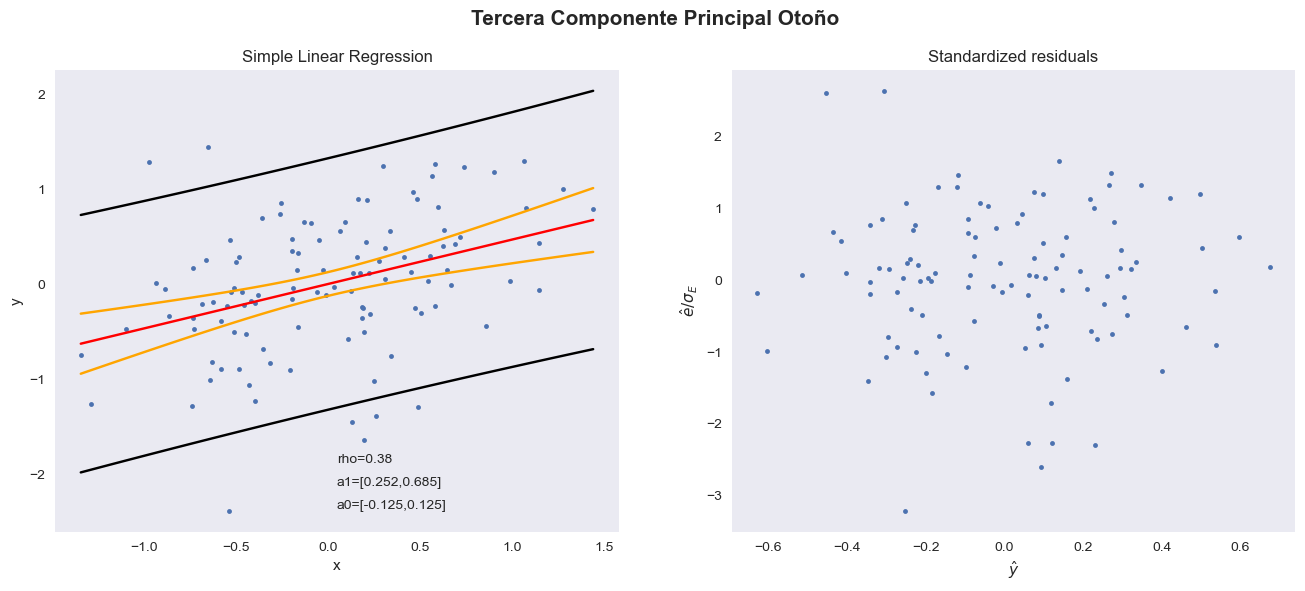

In [329]:
nao_son= ((diferencia_presion.groupby('time.season')-diferencia_presion.groupby('time.season').mean('time'))).groupby('time.season')/diferencia_presion.groupby('time.season').std('time')
nao_son= (nao_son.groupby('time.season')['SON']).groupby('time.year').mean()
a1, a0, rho, IC_a1, IC_a0, muY, AmuY, AY = regresLinSim(nao_son,PCs_nao_oto[:,0],'Primera Componente Principal Otoño')
a1, a0, rho, IC_a1, IC_a0, muY, AmuY, AY = regresLinSim(nao_son,PCs_nao_oto[:,1],'Segunda Componente Principal Otoño')
a1, a0, rho, IC_a1, IC_a0, muY, AmuY, AY = regresLinSim(nao_son,PCs_nao_oto[:,2],'Tercera Componente Principal Otoño')